# Модуль Б. Разведочный анализ данных

## 2.1 Кластеризация набора данных

Выберите модель кластеризации данных. Задача кластеризации – сегментация поездок, определение схожих группы объектов в каждом наборе данных. В результате должно быть выявлено не менее 3 и не более 5 кластеров. При кластеризации могут получиться группы поездок, схожие по различным характеристикам. Необходимо выявить такие характеристики и дать подробное описание каждого кластера.

### Загрузка библиотек

In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import pickle

import warnings
warnings.filterwarnings(action="ignore")

### Загрузка наборов данных

Загружаем наборы данных загруженные с прошлого модуля. Наборы обработаны от пустых значений, оставлены выбранные арибуты.

In [2]:
df2019 = pd.read_csv('result_df2019.csv')

In [3]:
df2020 = pd.read_csv('result_df2020.csv')

In [4]:
df2021 = pd.read_csv('result_df2021.csv')

In [5]:
df2019.head(5)

VendorID  passenger_count tpep_pickup_datetime  extra  month  PULocationID  \
0       2.0              1.0  2009-01-01 00:03:44    1.0      1           138   
1       2.0              1.0  2009-01-01 00:28:54    0.0      1           234   
2       2.0              1.0  2009-01-01 10:51:34    0.5      1           233   
3       2.0              1.0  2009-01-01 01:05:31    0.0      1           239   
4       2.0              3.0  2009-01-01 00:08:28    0.0      1            24   

   trip_distance  RatecodeID  DOLocationID  payment_type  fare_amount  \
0          10.67         1.0           164           1.0         36.0   
1           9.96         1.0           138           2.0         28.5   
2           2.21         1.0            90           2.0         12.5   
3           2.03         1.0           239           2.0          8.0   
4           3.30         1.0           230           2.0         13.5   

   mta_tax  tolls_amount  congestion_surcharge  total_amount  
0      0.5          6.12                   2.5         55.70  
1      0.5          6.12                   2.5         37.92  
2      0.5          0.00                   2.5         16.30  
3      0.5          0.00                   2.5         11.30  
4      0.5          0.00                   2.5         16.80

In [6]:
df2020.head(5)

VendorID  passenger_count tpep_pickup_datetime  extra  month  PULocationID  \
0       2.0              1.0  2020-01-01 14:12:04    0.0      1           132   
1       1.0              2.0  2020-01-08 08:23:09    2.5      1           239   
2       2.0              1.0  2020-01-15 18:10:11    1.0      1           229   
3       2.0              1.0  2020-01-15 19:24:59    1.0      1           186   
4       1.0              2.0  2020-01-09 22:10:33    3.0      1            13   

   trip_distance  RatecodeID  DOLocationID  payment_type  fare_amount  \
0          13.74         1.0           188           2.0         42.0   
1           1.60         1.0           236           1.0          8.5   
2           1.13         1.0           141           2.0          6.5   
3           1.74         1.0           161           1.0          9.0   
4           2.00         1.0           249           1.0         10.0   

   mta_tax  tolls_amount  congestion_surcharge  total_amount  
0      0.5           0.0                   0.0         42.80  
1      0.5           0.0                   2.5         15.30  
2      0.5           0.0                   2.5         10.80  
3      0.5           0.0                   2.5         15.96  
4      0.5           0.0                   2.5         15.87

In [7]:
df2021.head(5)

VendorID  passenger_count tpep_pickup_datetime  extra  month  PULocationID  \
0       2.0              1.0  2021-01-18 22:08:15    0.5      1           238   
1       2.0              1.0  2021-01-13 16:45:22    1.0      1            75   
2       2.0              1.0  2021-01-26 18:05:22    1.0      1           233   
3       1.0              1.0  2021-01-07 09:13:48    2.5      1            90   
4       1.0              1.0  2021-01-09 10:32:38    2.5      1           237   

   trip_distance  RatecodeID  DOLocationID  payment_type  fare_amount  \
0           1.21         1.0           142           1.0          5.5   
1           1.62         1.0           238           2.0         11.5   
2           1.26         1.0           100           1.0          7.0   
3           2.40         1.0           231           1.0         10.0   
4           1.20         1.0           163           1.0          7.0   

   mta_tax  tolls_amount  congestion_surcharge  total_amount  
0      0.5           0.0                   2.5         11.16  
1      0.5           0.0                   2.5         15.80  
2      0.5           0.0                   2.5         13.00  
3      0.5           0.0                   2.5         18.30  
4      0.5           0.0                   2.5         12.35

Будем работать со списком наборов данных, так как требуется провести кластеризацию для каждого из наборов, и легче будет провести эти действия перебирая элементы списка.

In [5]:
lst_df = [df2019, df2020, df2021]

### Нормализация

В прошлом модуле было доказано, что наборы данных не имеют нормализованной структуры, исправим это с помощью нормализации данных.

In [50]:
# Записываем колонки с числовыми значениями в список
columns = lst_df[0].columns
columns = [col for col in columns if df2019[col].dtype in ['int64', 'float64']]

# ?????
# for i in range(len(lst_df)):
#     for column in columns:
#         lst_df[i][column] = lst_df[i][column].abs()

In [7]:
# Список для удобства работы
lst_df_mms = []
for i in range(len(lst_df)):
    # Избавляемся от ненужных колонк
    columns = lst_df[i].columns
    columns = columns.difference(['tpep_pickup_datetime'])
    # Применяем MinMaxScaler к текущему DataFrame и добавляем в список
    lst_df_mms.append(pd.DataFrame(mms.fit_transform(lst_df[i].loc[:, lst_df[i].columns != 'tpep_pickup_datetime']), columns=columns))

In [8]:
lst_df_mms[0].head()

DOLocationID  PULocationID  RatecodeID  VendorID  congestion_surcharge  \
0      0.333333      0.111111    0.011421       0.0              0.518939   
1      0.333333      0.111111    0.000000       0.0              0.882576   
2      0.333333      0.111111    0.005710       0.0              0.878788   
3      0.333333      0.111111    0.000000       0.0              0.901515   
4      0.333333      0.333333    0.000000       0.0              0.087121   

      extra  fare_amount     month  mta_tax  passenger_count  payment_type  \
0  0.000232          0.0  0.617424     0.00         0.000088      0.008333   
1  0.000217          0.0  0.518939     0.25         0.000069      0.008333   
2  0.000048          0.0  0.337121     0.25         0.000030      0.008333   
3  0.000044          0.0  0.901515     0.25         0.000019      0.008333   
4  0.000072          0.0  0.867424     0.25         0.000033      0.008333   

   tolls_amount  total_amount  trip_distance  
0      0.006722      0.909091       0.000136  
1      0.006722      0.909091       0.000092  
2      0.000000      0.909091       0.000040  
3      0.000000      0.909091       0.000027  
4      0.000000      0.909091       0.000041

In [12]:
lst_df_mms[0].describe().T

count      mean       std  min       25%       50%  \
DOLocationID          16339164.0  0.216273  0.161369  0.0  0.000000  0.333333   
PULocationID          16339164.0  0.172974  0.133180  0.0  0.111111  0.111111   
RatecodeID            16339164.0  0.013124  0.014490  0.0  0.000000  0.005710   
VendorID              16339164.0  0.660154  0.163291  0.0  0.545455  0.636364   
congestion_surcharge  16339164.0  0.612814  0.249439  0.0  0.435606  0.609848   
extra                 16339164.0  0.000066  0.000262  0.0  0.000022  0.000036   
fare_amount           16339164.0  0.000632  0.008130  0.0  0.000000  0.000000   
month                 16339164.0  0.605967  0.265844  0.0  0.401515  0.609848   
mta_tax               16339164.0  0.073176  0.120662  0.0  0.000000  0.000000   
passenger_count       16339164.0  0.000033  0.000249  0.0  0.000016  0.000023   
payment_type          16339164.0  0.008281  0.000732  0.0  0.008333  0.008333   
tolls_amount          16339164.0  0.000437  0.002012  0.0  0.000000  0.000000   
total_amount          16339164.0  0.833597  0.250859  0.0  0.909091  0.909091   
trip_distance         16339164.0  0.000048  0.000250  0.0  0.000027  0.000036   

                           75%  max  
DOLocationID          0.333333  1.0  
PULocationID          0.222222  1.0  
RatecodeID            0.028552  1.0  
VendorID              0.818182  1.0  
congestion_surcharge  0.878788  1.0  
extra                 0.000067  1.0  
fare_amount           0.000000  1.0  
month                 0.878788  1.0  
mta_tax               0.250000  1.0  
passenger_count       0.000036  1.0  
payment_type          0.008333  1.0  
tolls_amount          0.000000  1.0  
total_amount          0.909091  1.0  
trip_distance         0.000052  1.0

In [13]:
lst_df_mms[1].describe().T

count      mean       std  min       25%       50%  \
DOLocationID          9773911.0  0.667367  0.471156  0.0  0.000000  1.000000   
PULocationID          9773911.0  0.163097  0.123606  0.0  0.111111  0.111111   
RatecodeID            9773911.0  0.009512  0.010991  0.0  0.000000  0.004424   
VendorID              9773911.0  0.307951  0.348160  0.0  0.000000  0.090909   
congestion_surcharge  9773911.0  0.619950  0.250875  0.0  0.469697  0.609848   
extra                 9773911.0  0.000016  0.000351  0.0  0.000006  0.000010   
fare_amount           9773911.0  0.000498  0.007850  0.0  0.000000  0.000000   
month                 9773911.0  0.610036  0.267566  0.0  0.401515  0.609848   
mta_tax               9773911.0  0.070127  0.121128  0.0  0.000000  0.000000   
passenger_count       9773911.0  0.000018  0.000328  0.0  0.000010  0.000013   
payment_type          9773911.0  0.016143  0.001276  0.0  0.016234  0.016234   
tolls_amount          9773911.0  0.000289  0.001665  0.0  0.000000  0.000000   
total_amount          9773911.0  0.831446  0.254080  0.0  0.909091  0.909091   
trip_distance         9773911.0  0.000027  0.000329  0.0  0.000017  0.000021   

                           75%  max  
DOLocationID          1.000000  1.0  
PULocationID          0.111111  1.0  
RatecodeID            0.022122  1.0  
VendorID              0.636364  1.0  
congestion_surcharge  0.882576  1.0  
extra                 0.000017  1.0  
fare_amount           0.000000  1.0  
month                 0.882576  1.0  
mta_tax               0.250000  1.0  
passenger_count       0.000020  1.0  
payment_type          0.016234  1.0  
tolls_amount          0.000000  1.0  
total_amount          0.909091  1.0  
trip_distance         0.000029  1.0

In [14]:
lst_df_mms[2].describe().T

count      mean       std  min       25%       50%  \
DOLocationID          12065206.0  0.690484  0.462294  0.0  0.000000  1.000000   
PULocationID          12065206.0  0.012746  0.009227  0.0  0.008929  0.008929   
RatecodeID            12065206.0  0.012050  0.014220  0.0  0.000000  0.005710   
VendorID              12065206.0  0.583856  0.293616  0.0  0.363636  0.636364   
congestion_surcharge  12065206.0  0.622422  0.248836  0.0  0.496212  0.609848   
extra                 12065206.0  0.000232  0.000489  0.0  0.000081  0.000135   
fare_amount           12065206.0  0.000899  0.019942  0.0  0.000000  0.000000   
month                 12065206.0  0.614428  0.266977  0.0  0.424242  0.609848   
mta_tax               12065206.0  0.062364  0.117882  0.0  0.000000  0.000000   
passenger_count       12065206.0  0.000033  0.000289  0.0  0.000016  0.000024   
payment_type          12065206.0  0.109164  0.008992  0.0  0.109890  0.109890   
tolls_amount          12065206.0  0.000415  0.001976  0.0  0.000000  0.000000   
total_amount          12065206.0  0.839373  0.241907  0.0  0.909091  0.909091   
trip_distance         12065206.0  0.000048  0.000290  0.0  0.000029  0.000037   

                           75%  max  
DOLocationID          1.000000  1.0  
PULocationID          0.008929  1.0  
RatecodeID            0.028552  1.0  
VendorID              0.818182  1.0  
congestion_surcharge  0.882576  1.0  
extra                 0.000239  1.0  
fare_amount           0.000000  1.0  
month                 0.882576  1.0  
mta_tax               0.000000  1.0  
passenger_count       0.000035  1.0  
payment_type          0.109890  1.0  
tolls_amount          0.000000  1.0  
total_amount          0.909091  1.0  
trip_distance         0.000051  1.0

Данные были нормализованы, т.е. минимальное значение равно 0, макимальное равно 1.

### Определение количества кластеров

Для того, чтобы определить оптимальное количество кластеров используем метод локтя, в точке где график резко уходит в право, там и будет наилучшее количестов кластеров.

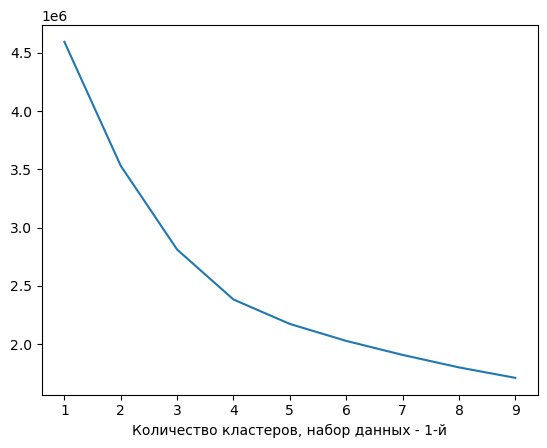

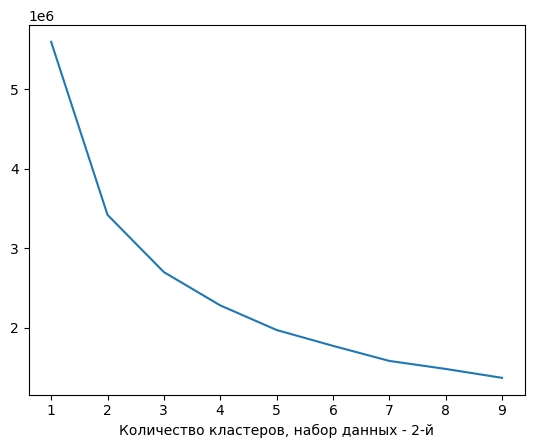

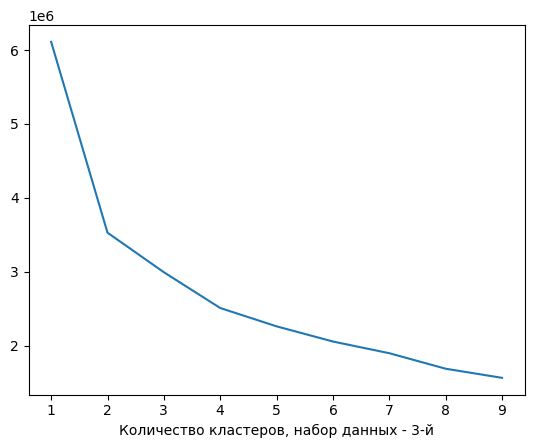

In [9]:
for i in range(len(lst_df_mms)):
    X = lst_df_mms[i]
    kmean_set = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}
    inertia_list = []
    
    # Проводим кластеризацию с разным количеством кластеров
    for k in range(1, 10):   
        kmeans = KMeans(n_clusters=k, **kmean_set)
        kmeans.fit(X)
        inertia_list.append(kmeans.inertia_) 
    
    # Выводим график с кластерами
    plt.plot(range(1, 10), inertia_list)  
    plt.xticks(range(1, 10))
    plt.xlabel(f"Количество кластеров, набор данных - {i+1}-й")
    plt.show()

В первом наборе данных не понятно оптимальное количество кластеров. В следующих двух наборах это значение ближе к 5 - 6. По условию требуется использовать от 3х д 5ти кластеров, потому будем использовать 5 кластеров.

In [10]:
# переменая с количеством кластеров для последующего обучения моделей
n_clusters = 5

### Кластеризация

#### План:

    Определить какие использовать методы кластериззации;
    Уменьшить размерность до 2х с помощью PCA;
    Провести обучение для каждого метода;
    Построить график для определения характеристик кластеров;
    Дать названия кластерам;
    Выделить три главные характеристики;

#### Выбор методов кластеризации

Будем использовать данные методы кластеризаций:

    KMeans:
        подходит для больших наборов данных;
        работает лучше с оптимальным количеством признаков, в прошлом модуле, были определены эти принаки;

    Birch:
        подходит для больших наборов данных;
        лучше работает с нормализованными данными;
        признаки должны быть слабо скоррелированны;

    GaussianMixture:
        подходит для больших наборов данных;
        лучше работает с нормализованными данными;

Можно сказать, что эти три модели подходят для кластеризации данных наборов данных. Иерархические модели нам не подходят, так как они предназначены для более маленьких выборок.

#### Уменьшение размерности

Для лучшей кластеризаций и последующей визуализации, воспользуемся методом PCA и уменьшим размерность данных до 2х.

In [11]:
lst_pca = []
for i in range(len(lst_df_mms)):
    X = lst_df_mms[i]
    
    # Уменьшение размерности датафрейма до 2-х измерений
    pca = PCA(n_components=2)
    pca.fit(X)
    
    x_pca = pca.transform(X)
    lst_pca.append(x_pca)

#### KMeans

Обучим модель, записав в её в список, для дальнейшего урощения работы с метриками. Так же добавим в наборы данных столбец с кластерами для удобства опредления характеристик.

In [12]:
lst_kmeans = []
for i in range(len(lst_pca)):
    # Модель KMeans
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(lst_pca[i])
    lst_kmeans.append(kmeans)

In [51]:
for i in range(len(lst_kmeans)):
    print(f'Набор данных {i}')
    labels = lst_kmeans[i].labels_
    # Подсчитываем количество записей в каждом кластере
    unique, counts = np.unique(labels, return_counts=True)
    # Выводим количество записей в каждом кластере
    for cluster, count in zip(unique, counts):
        print(f"Кластер {cluster}: {count} записей")

Набор данных 0
Кластер 0: 4283082 записей
Кластер 1: 2702512 записей
Кластер 2: 3478173 записей
Кластер 3: 1086359 записей
Кластер 4: 4789038 записей
Набор данных 1
Кластер 0: 1249312 записей
Кластер 1: 4323580 записей
Кластер 2: 2196850 записей
Кластер 3: 949890 записей
Кластер 4: 1054279 записей
Набор данных 2
Кластер 0: 2992496 записей
Кластер 1: 2221990 записей
Кластер 2: 1824493 записей
Кластер 3: 1512387 записей
Кластер 4: 3513840 записей


Количество кластеров верной, данные распределены, потому записываем значения в набор данных атрибут KMeans_clust

In [13]:
for i in range(len(lst_kmeans)):
    lst_df[i]['KMeans_clust'] = lst_kmeans[i].labels_

Создадим словарик и список со столбцами которые могут являться изменяемыми характеристиками.

In [14]:
columns = lst_df[0].columns
columns = [col for col in columns if df2019[col].dtype in ['int64', 'float64']]
dick_agg = {}

for i in range(len(columns)):
    dick_agg[columns[i]] = ['min', 'mean', 'max']

dick_agg

{'VendorID': ['min', 'mean', 'max'],
 'passenger_count': ['min', 'mean', 'max'],
 'extra': ['min', 'mean', 'max'],
 'month': ['min', 'mean', 'max'],
 'PULocationID': ['min', 'mean', 'max'],
 'trip_distance': ['min', 'mean', 'max'],
 'RatecodeID': ['min', 'mean', 'max'],
 'DOLocationID': ['min', 'mean', 'max'],
 'payment_type': ['min', 'mean', 'max'],
 'fare_amount': ['min', 'mean', 'max'],
 'mta_tax': ['min', 'mean', 'max'],
 'tolls_amount': ['min', 'mean', 'max'],
 'congestion_surcharge': ['min', 'mean', 'max'],
 'total_amount': ['min', 'mean', 'max']}

Для определения атрибутов которые меняются в зависимости от кластера, выведем график с отображением значением атрибутов в минимальной, среденей и максимальной позициий. Если графики будут отличаться в значениях, то можно опредлить эти признаки, как характеристики.


Набор данных - 1й



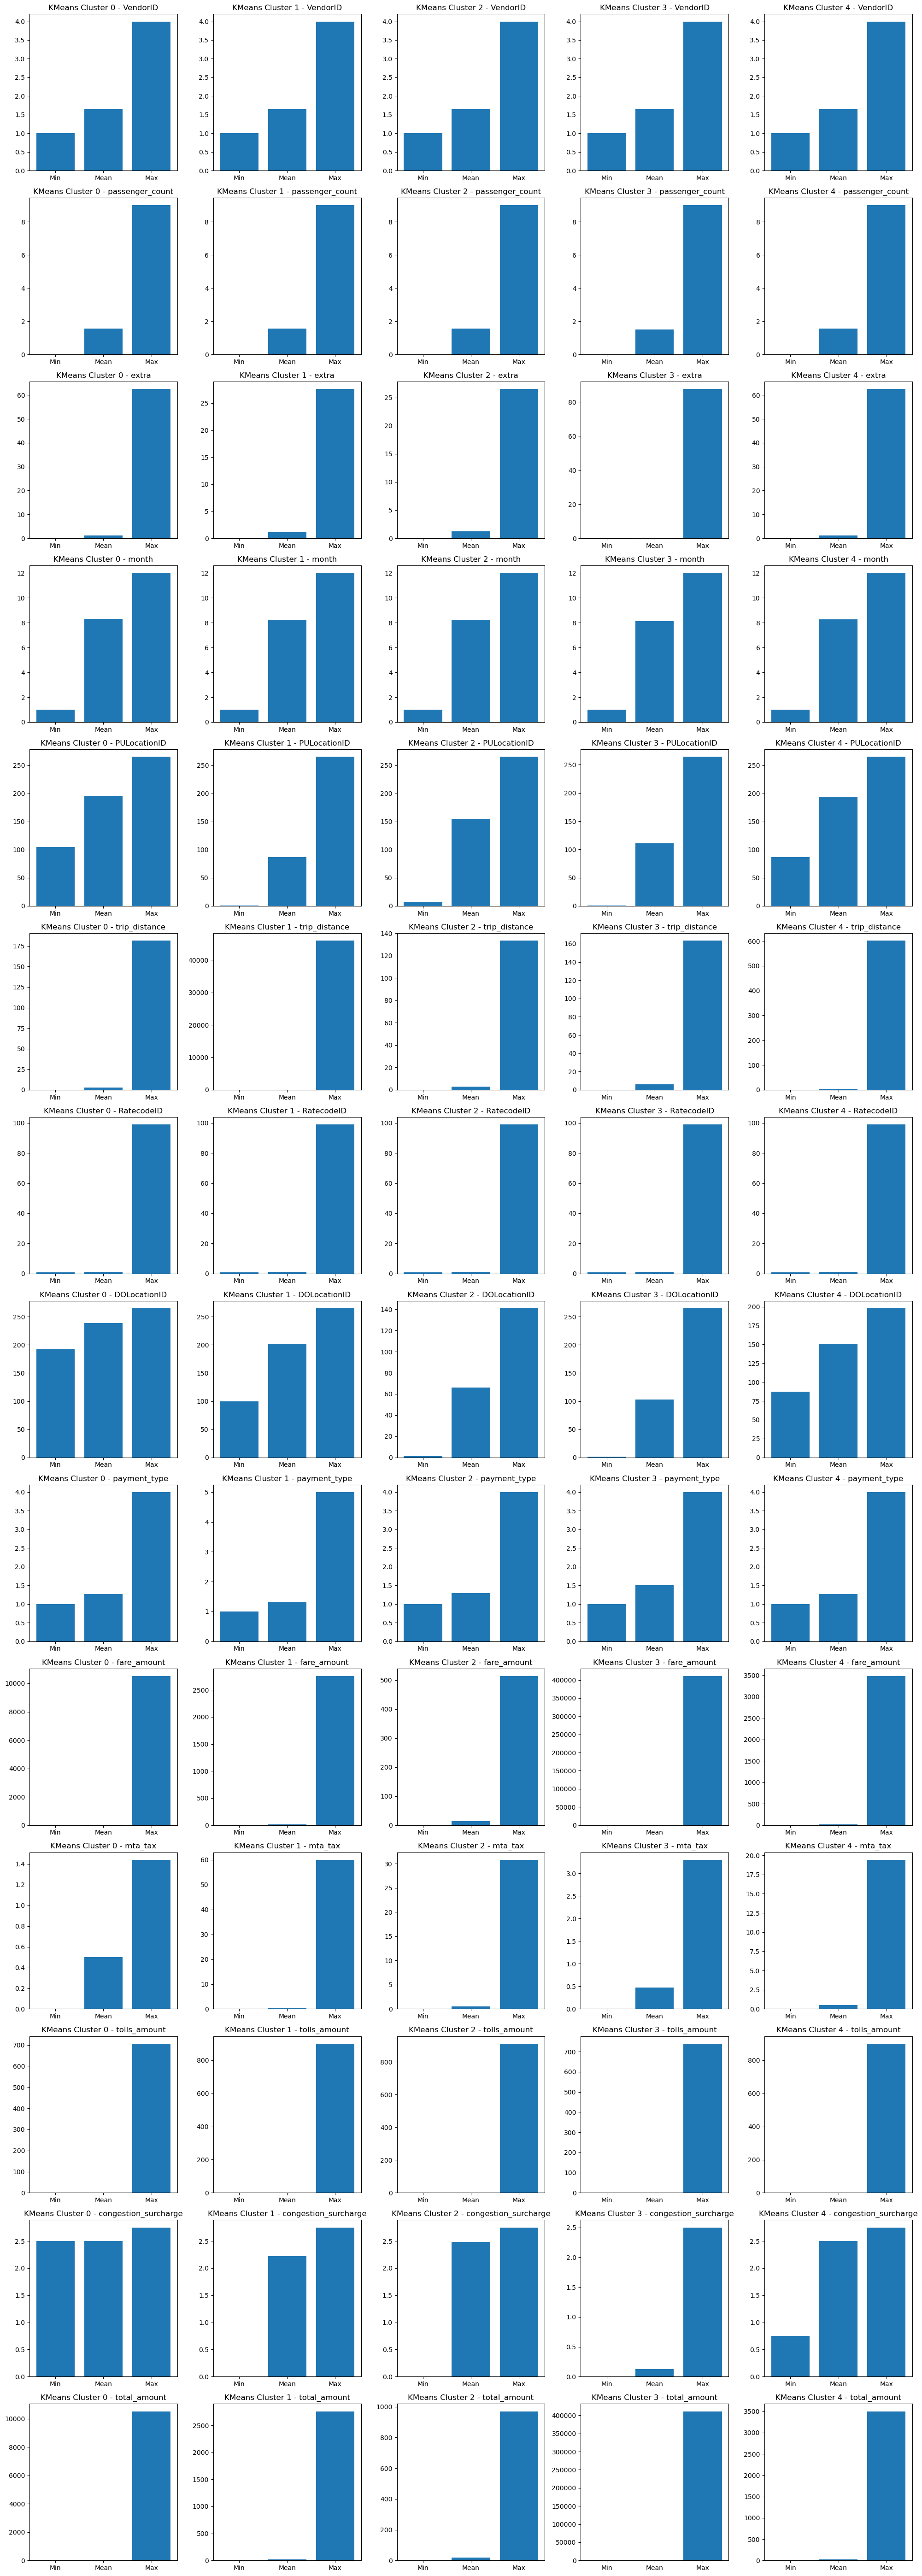


Набор данных - 2й



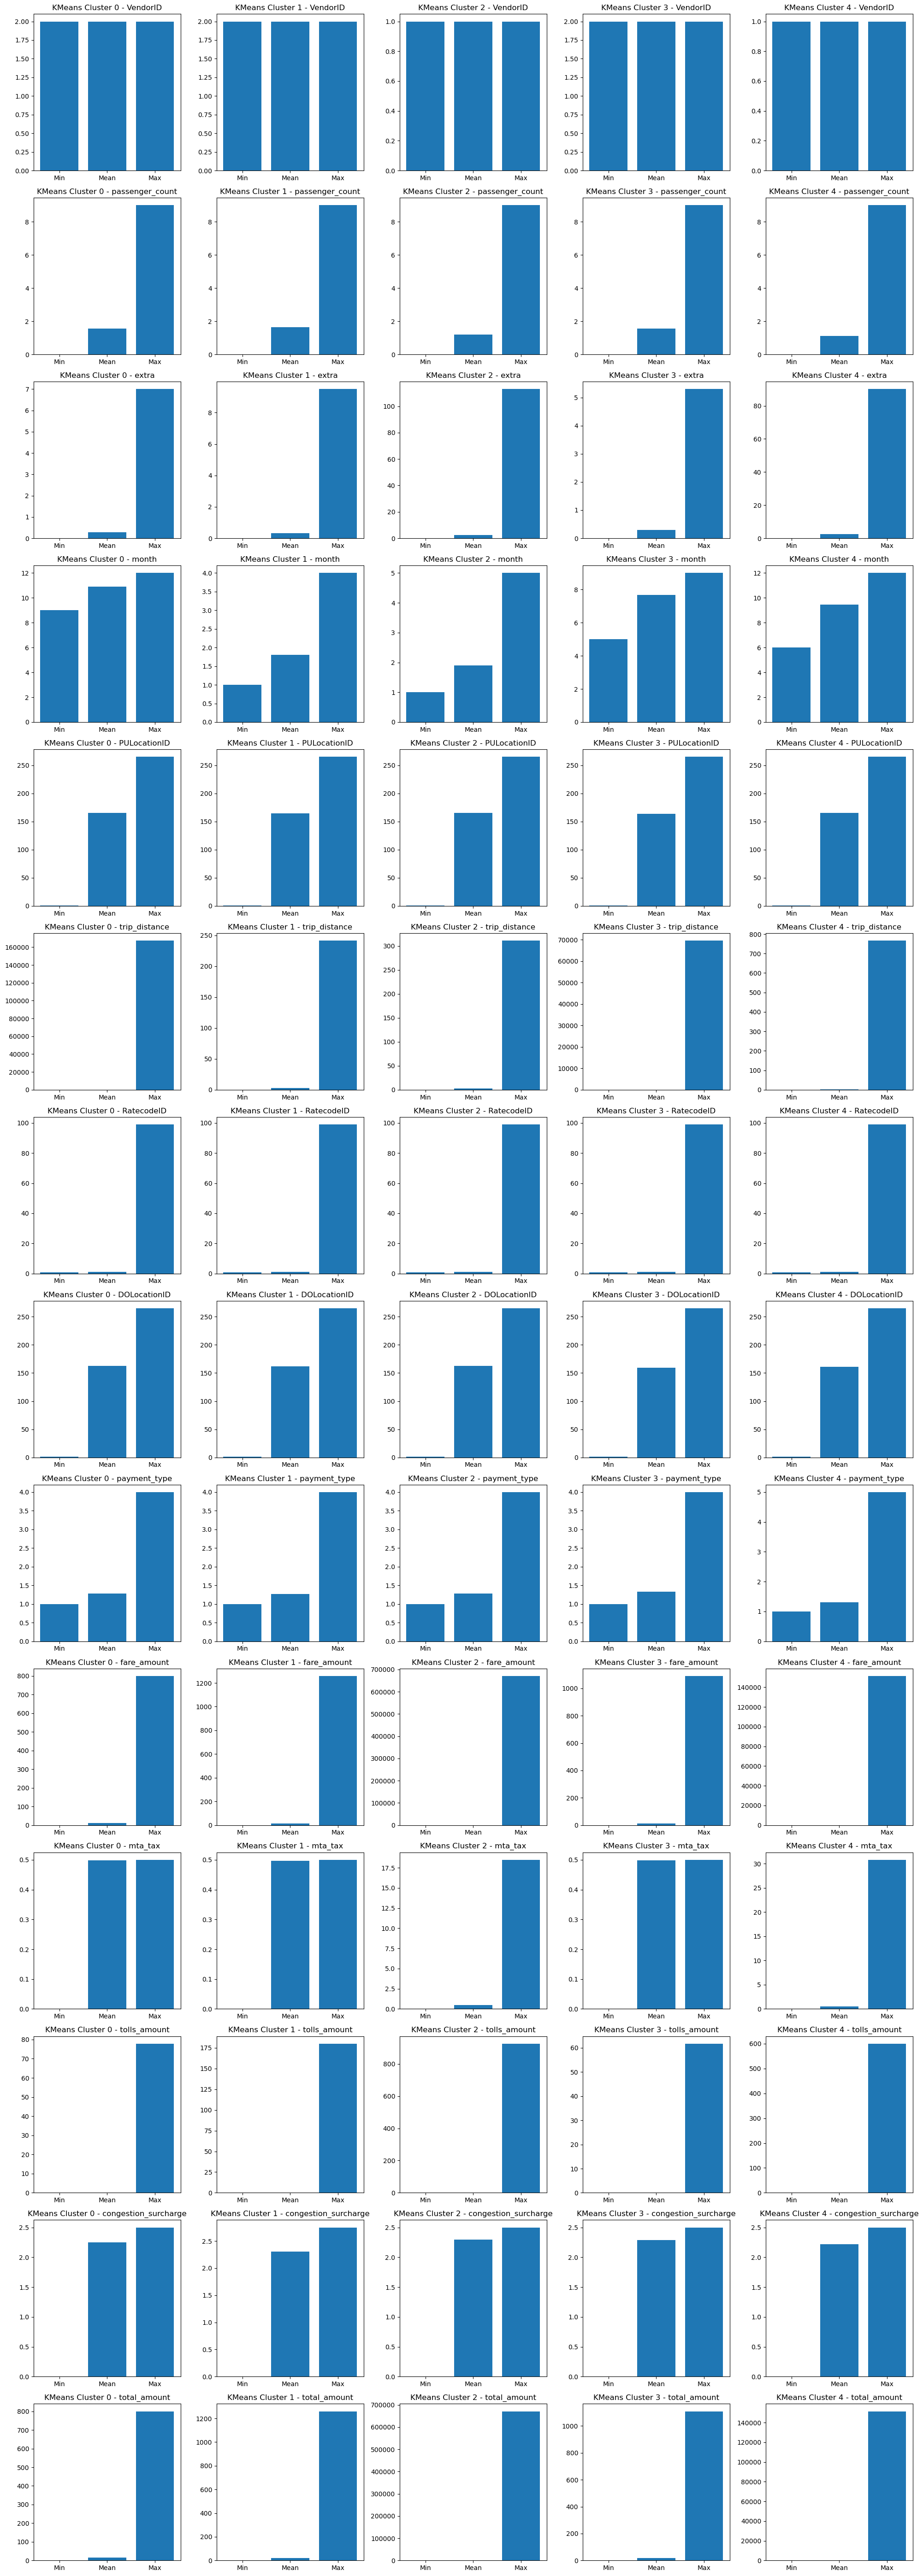


Набор данных - 3й



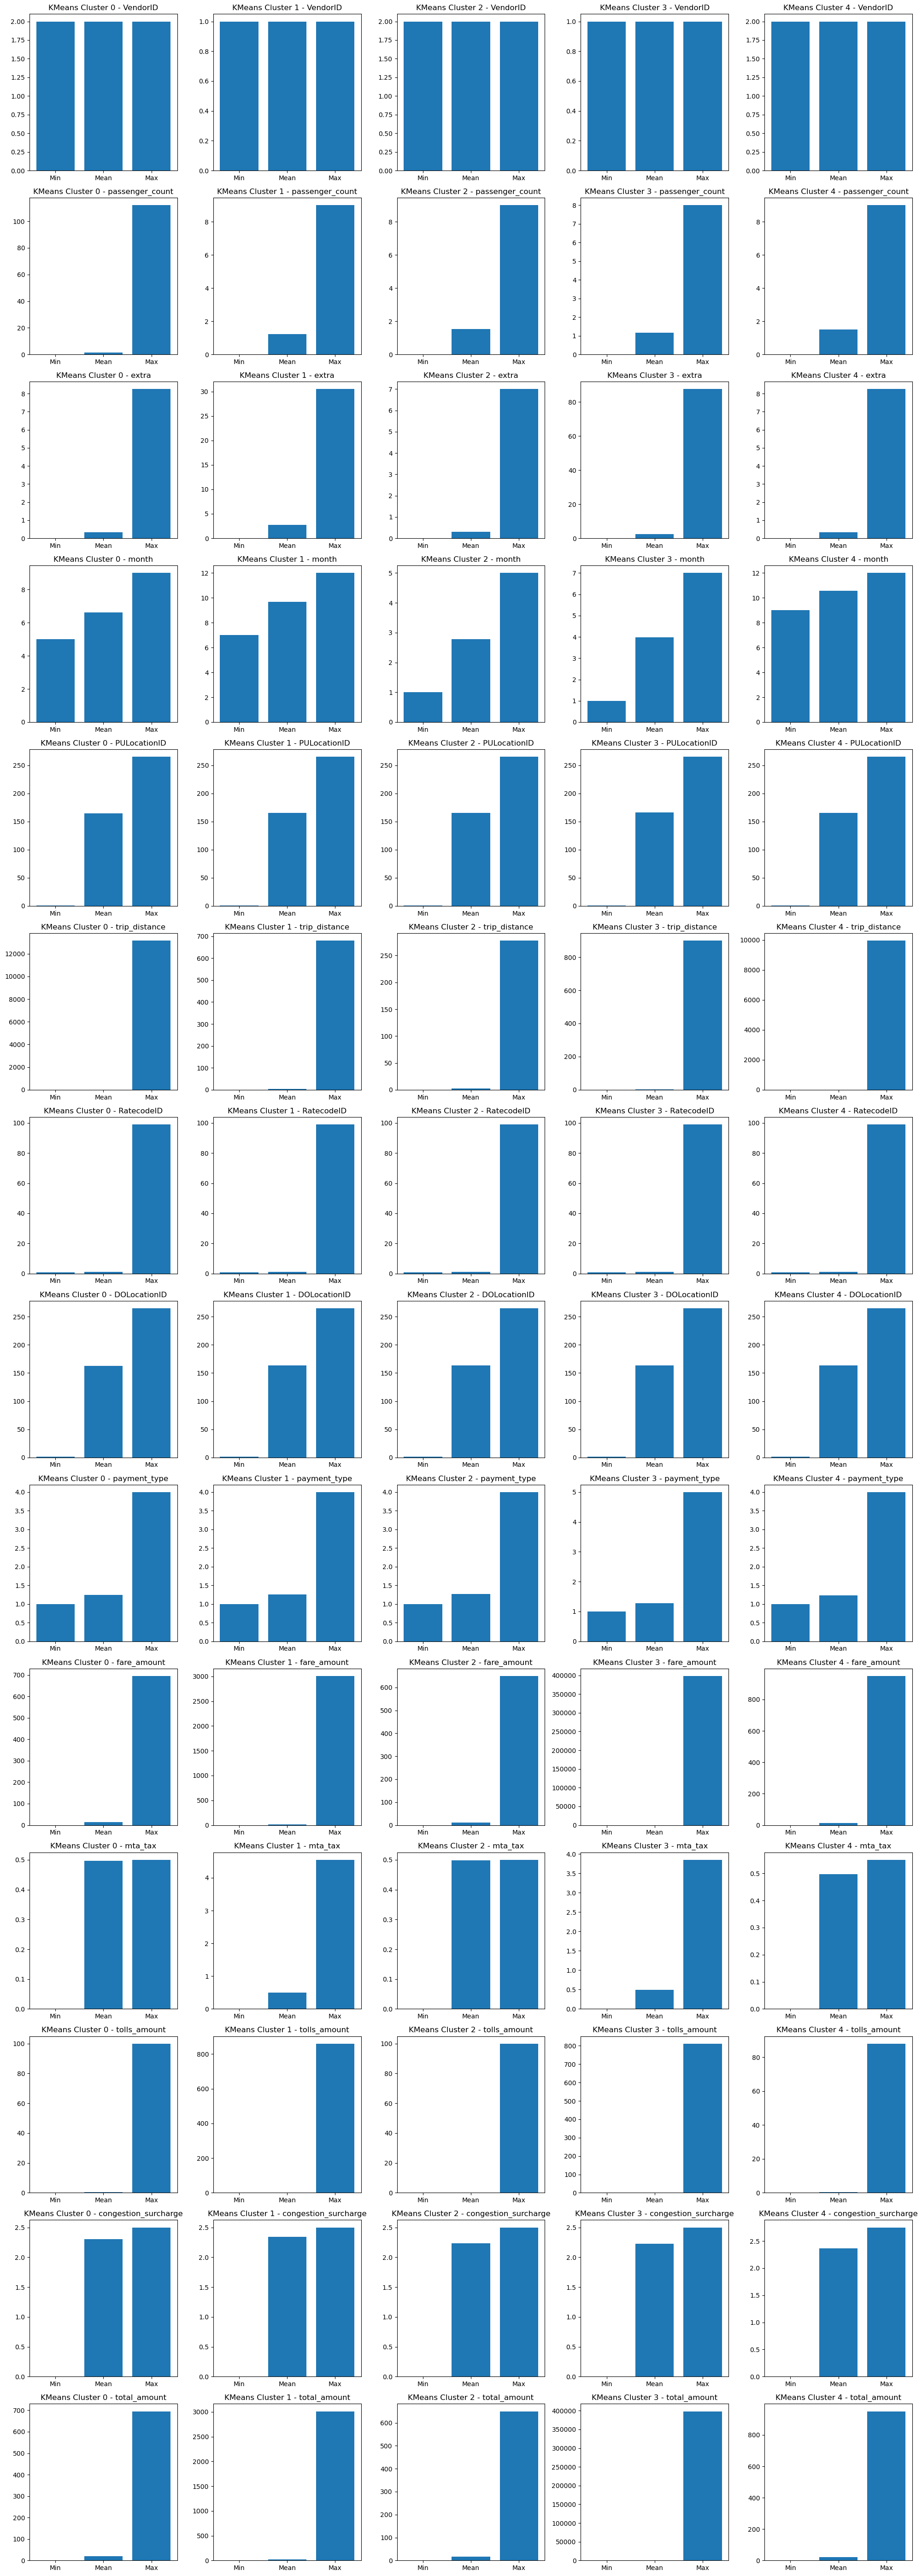

In [15]:
for i in range(len(lst_df)):
    df = lst_df[i]
    print(f'\nНабор данных - {i+1}й\n')
    # Группировка данных по кластерам
    grouped = df.groupby('KMeans_clust')
    
    # Вычисление минимального, среднего и максимального значения для каждого признака в каждом кластере
    summary_stats = grouped.agg(dick_agg)
    
    # Построение графика
    fig, axs = plt.subplots(len(columns), len(summary_stats), figsize=(20, 4 * len(columns)))
    
    for j, feature in enumerate(columns):
        for i, (cluster, stats) in enumerate(summary_stats.iterrows()):
            axs[j, i].bar(['Min', 'Mean', 'Max'], stats[feature])
            axs[j, i].set_title(f'KMeans Cluster {cluster} - {feature}')
    
    plt.tight_layout()
    plt.show()

По графику хорошо видны разичия в кластерах. Просмотрев данные, можно заметить, что в основном меняются данные признаки: trip_distance, fare_amount, total_amount. Так как гафик сложно просматривать для конкретных признаков, выведем просто значения с данными атрибутами для анализа подробного описания кластеров.

In [16]:
columns_specifications = ['trip_distance','fare_amount','total_amount']
dick_specifications = {}

for i in range(len(columns_specifications)):
    dick_specifications[columns_specifications[i]] = ['min', 'mean', 'max']

dick_specifications

{'trip_distance': ['min', 'mean', 'max'],
 'fare_amount': ['min', 'mean', 'max'],
 'total_amount': ['min', 'mean', 'max']}

Просмотрим наборы данных в сравнении в каждом кластере. Данный способ нужен, чтобы опредлить как расположились кластеры в разных наборах и насколько они отличаются.

In [17]:
for clust in range(5):
    print(f'\nКластер {clust}:')
    for i in range(len(lst_df)):
        df = lst_df[i]
        print(f'Набор данных - {i+1}й:')
        for column in columns_specifications:
            # Группировка данных по кластерам
            grouped = df.loc[:, [column, 'KMeans_clust']].groupby('KMeans_clust').get_group(clust)
            print(f'\t{column}: min - {grouped.min()[0]}; mean - {grouped.mean()[0]}; max - {grouped.max()[0]};')
    print('')


Кластер 0:
Набор данных - 1й:
	trip_distance: min - 0.0; mean - 2.4910286704760707; max - 181.53;
	fare_amount: min - 0.0; mean - 11.69890956558852; max - 10524.0;
	total_amount: min - 0.0; mean - 17.736503366034075; max - 10527.8;
Набор данных - 2й:
	trip_distance: min - 0.0; mean - 2.705929471581159; max - 167329.45;
	fare_amount: min - 0.0; mean - 11.262183625867673; max - 800.0;
	total_amount: min - 0.0; mean - 16.718320739735145; max - 800.3;
Набор данных - 3й:
	trip_distance: min - 0.0; mean - 3.1888053952285973; max - 13155.52;
	fare_amount: min - 0.0; mean - 13.15502647956756; max - 695.0;
	total_amount: min - 0.0; mean - 19.410257474028366; max - 695.3;


Кластер 1:
Набор данных - 1й:
	trip_distance: min - 0.0; mean - 3.038240525851504; max - 45977.22;
	fare_amount: min - 0.0; mean - 14.224003227367735; max - 2759.07;
	total_amount: min - 0.0; mean - 20.08478219153142; max - 2759.37;
Набор данных - 2й:
	trip_distance: min - 0.0; mean - 2.8929776435268924; max - 241.64;
	fare_

Кластеры существенно отличаются, значит для каждого набора дынных нужно будет переименовывать кластеры по отдельности. Это будет производится после того как будет определён лучшии метод кластеризации.

Далее для удобства просмотра кластеров по наборам, сделаем слеедующий вывод:

In [18]:
for df_i in range(len(lst_df)):
    df = lst_df[df_i]
    print(f'\nНабор данных - {df_i+1}й:')
    for i in range(5):
        print(f'Кластер {i}:')
        for column in columns_specifications:
            # Группировка данных по кластерам
            grouped = df.loc[:, [column, 'KMeans_clust']].groupby('KMeans_clust').get_group(i)
            print(f'\t{column}: min - {grouped.min()[0]}; mean - {grouped.mean()[0]}; max - {grouped.max()[0]};')
    print('')


Набор данных - 1й:
Кластер 0:
	trip_distance: min - 0.0; mean - 2.4910286704760707; max - 181.53;
	fare_amount: min - 0.0; mean - 11.69890956558852; max - 10524.0;
	total_amount: min - 0.0; mean - 17.736503366034075; max - 10527.8;
Кластер 1:
	trip_distance: min - 0.0; mean - 3.038240525851504; max - 45977.22;
	fare_amount: min - 0.0; mean - 14.224003227367735; max - 2759.07;
	total_amount: min - 0.0; mean - 20.08478219153142; max - 2759.37;
Кластер 2:
	trip_distance: min - 0.0; mean - 3.0156210027505828; max - 133.52;
	fare_amount: min - 0.0; mean - 13.262716509500821; max - 514.5;
	total_amount: min - 0.0; mean - 19.451205837087436; max - 970.3;
Кластер 3:
	trip_distance: min - 0.0; mean - 5.883328752281707; max - 163.45;
	fare_amount: min - 0.0; mean - 22.851495426465824; max - 411042.01;
	total_amount: min - 0.0; mean - 27.42334910466982; max - 411042.81;
Кластер 4:
	trip_distance: min - 0.0; mean - 2.9205126770762724; max - 601.6;
	fare_amount: min - 0.0; mean - 13.14469530415085

Так кластеры меняются в разных наборах, выделим примерные характеристики и их значения для каждого кластера:

    Кластер 1 - "Проезд - минимум": в данном кластере минимальное среднее значение(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 0; 
        Набор 2 - кластер под номером 4;
        Набор 3 - кластер под номером 2;

    Кластер 2 - "Проезд - меньше среднего": в данном кластере среднее значение ниже среднего(из всех кластеров) в trip_distance и fare_amount:
        Набор 1 - кластер под номером 4;
        Набор 2 - кластер под номером 2;
        Набор 3 - кластер под номером 3;

    Кластер 3 - "Проезд - средний": в данном кластере среднее значение находится в середине(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 2; 
        Набор 2 - кластер под номером 0;
        Набор 3 - кластер под номером 1;

    Кластер 4 - "Проезд - больше среднего": в данном кластере среднее значение выше среднего(из всех кластеров) в trip_distance и fare_amount:
        Набор 1 - кластер под номером 1;
        Набор 2 - кластер под номером 3;
        Набор 3 - кластер под номером 0;

    Кластер 5 - "Проезд - высокий": в данном кластере максимальное среднее значение(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 3; 
        Набор 2 - кластер под номером 1;
        Набор 3 - кластер под номером 4;

### Birch

Следующую модель обучим, так же записав в её в список, для дальнейшего урощения работы с метриками. Так же добавим в наборы данных столбец с кластерами для удобства опредления характеристик.

In [19]:
lst_birch = []
for i in range(len(lst_pca)):
    birch = Birch(threshold=0.01, n_clusters=n_clusters).fit(lst_pca[i])
    birch.predict(lst_pca[i])
    lst_birch.append(birch)

In [20]:
for i in range(len(lst_birch)):
    print(f'Набор данных {i}')
    labels = lst_birch[i].labels_
    # Подсчитываем количество записей в каждом кластере
    unique, counts = np.unique(labels, return_counts=True)
    # Выводим количество записей в каждом кластере
    for cluster, count in zip(unique, counts):
        print(f"Кластер {cluster}: {count} записей")

Набор данных 0
Кластер 0: 1231700 записей
Кластер 1: 7849297 записей
Кластер 2: 358350 записей
Кластер 3: 3102411 записей
Кластер 4: 3797406 записей
Набор данных 1
Кластер 0: 1106067 записей
Кластер 1: 912811 записей
Кластер 2: 4390513 записей
Кластер 3: 2145062 записей
Кластер 4: 1219458 записей
Набор данных 2
Кластер 0: 2560829 записей
Кластер 1: 4274836 записей
Кластер 2: 1173548 записей
Кластер 3: 2808698 записей
Кластер 4: 1247295 записей


Количество кластеров верное, данные распределены, потому записываем значения в набор данных атрибут Birch_clust

In [21]:
for i in range(len(lst_birch)):
    lst_df[i]['Birch_clust'] = lst_birch[i].labels_

С данной моделью проделаем те же действай. Для опрделения атрибутов которые меняются в зависимости от кластера, выведем график с отображением значением атрибутов в минимальной, среденей и максимальной позициий. Если графики будут отличаться в значениях, то можно опредлить эти признаки, как характеристики.


Набор данных - 1й



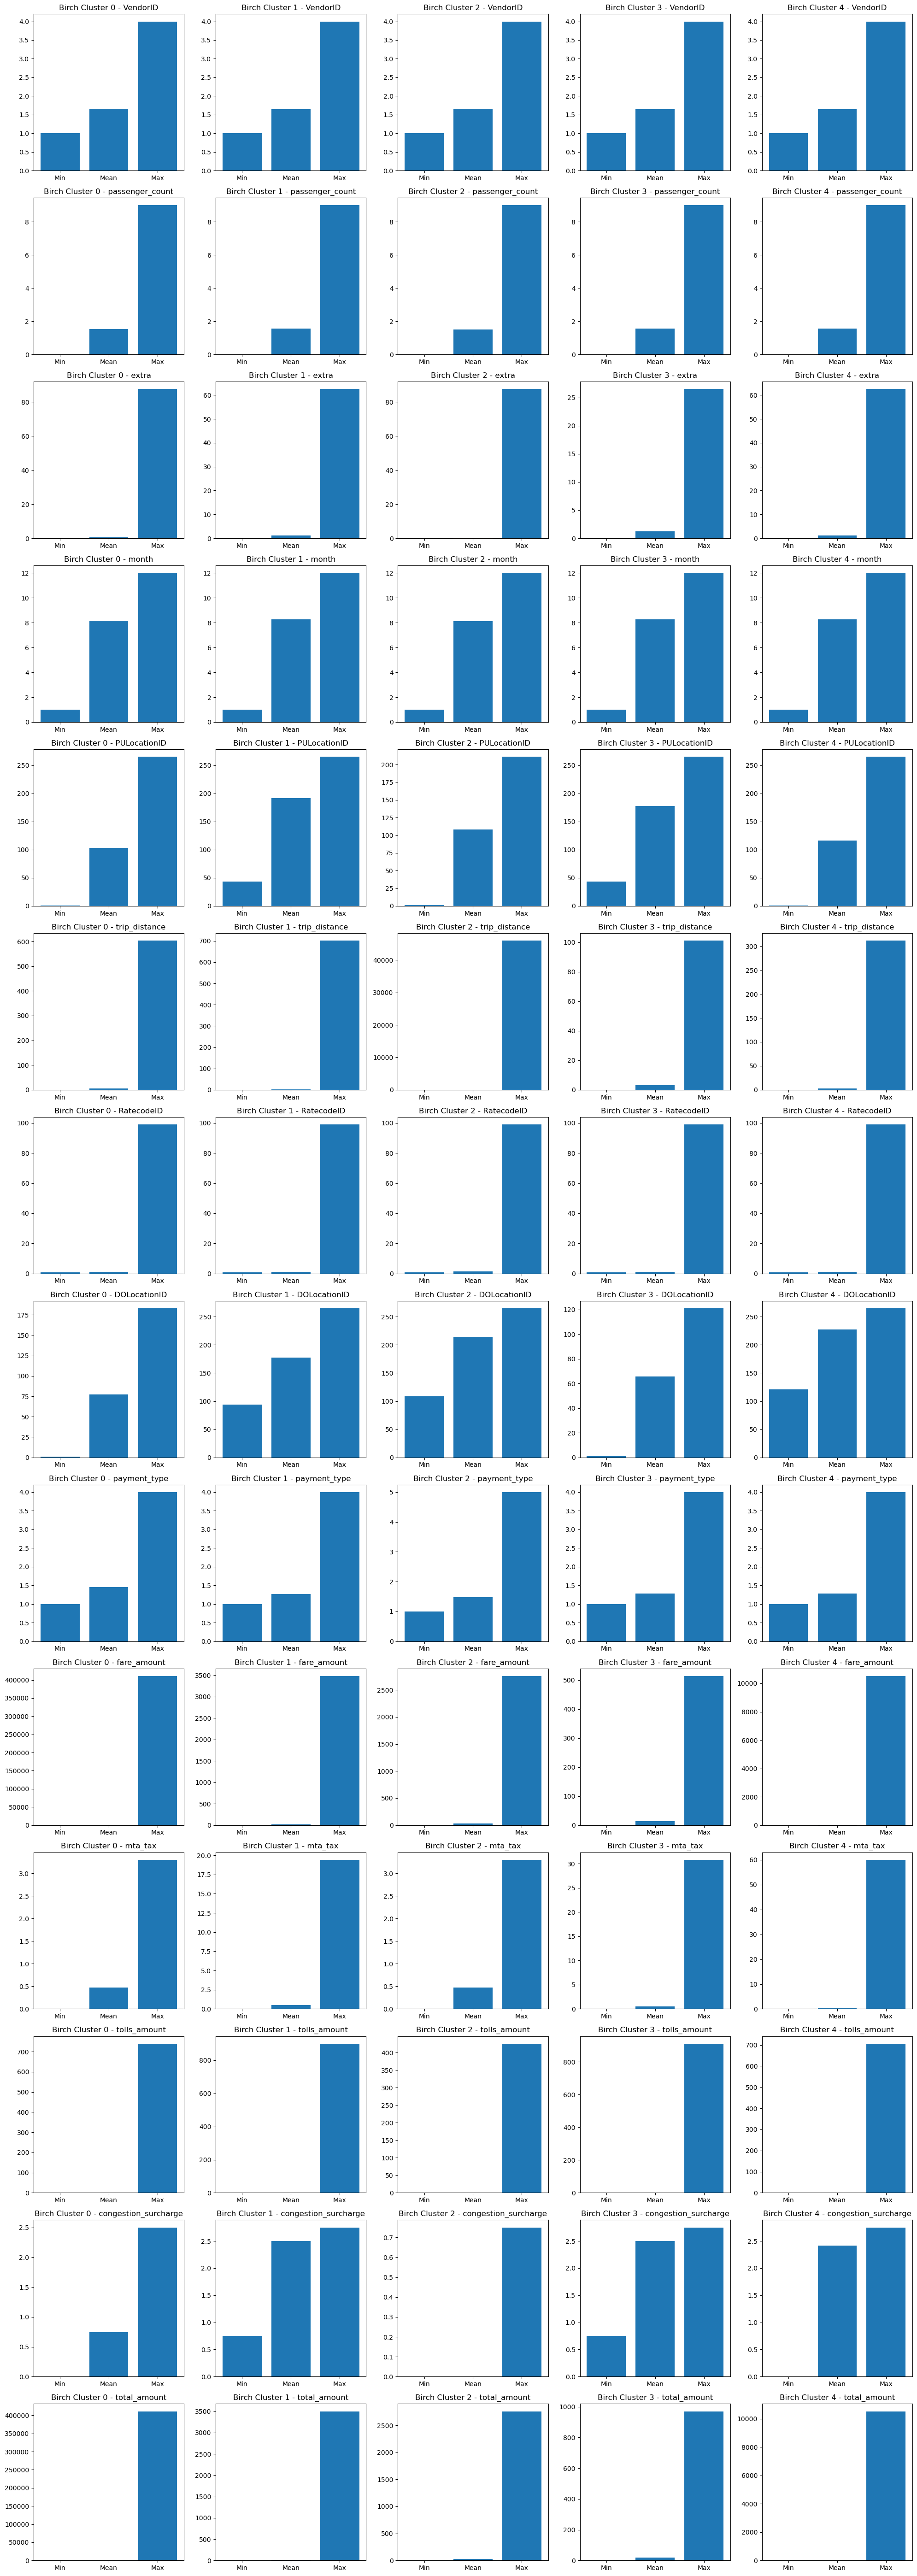


Набор данных - 2й



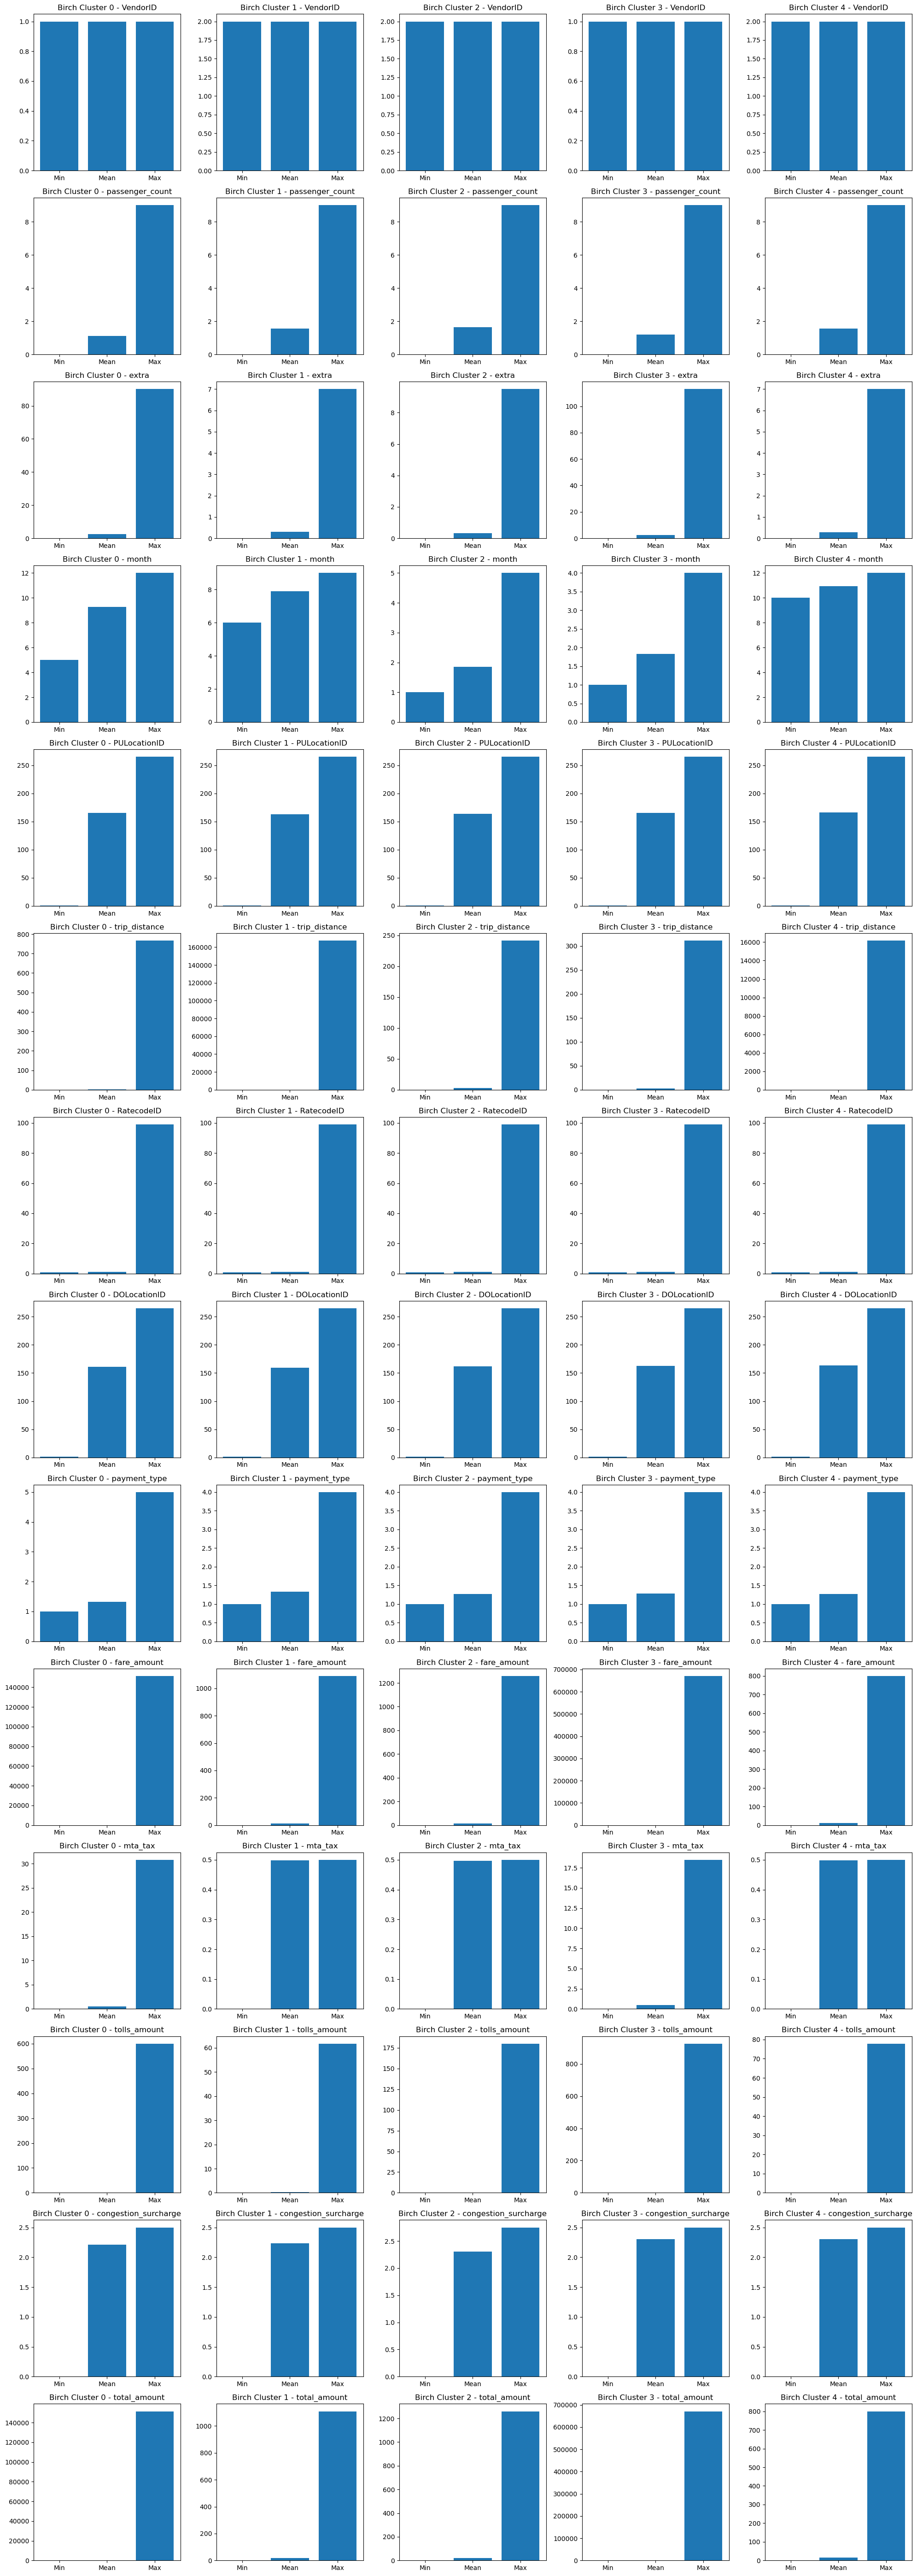


Набор данных - 3й



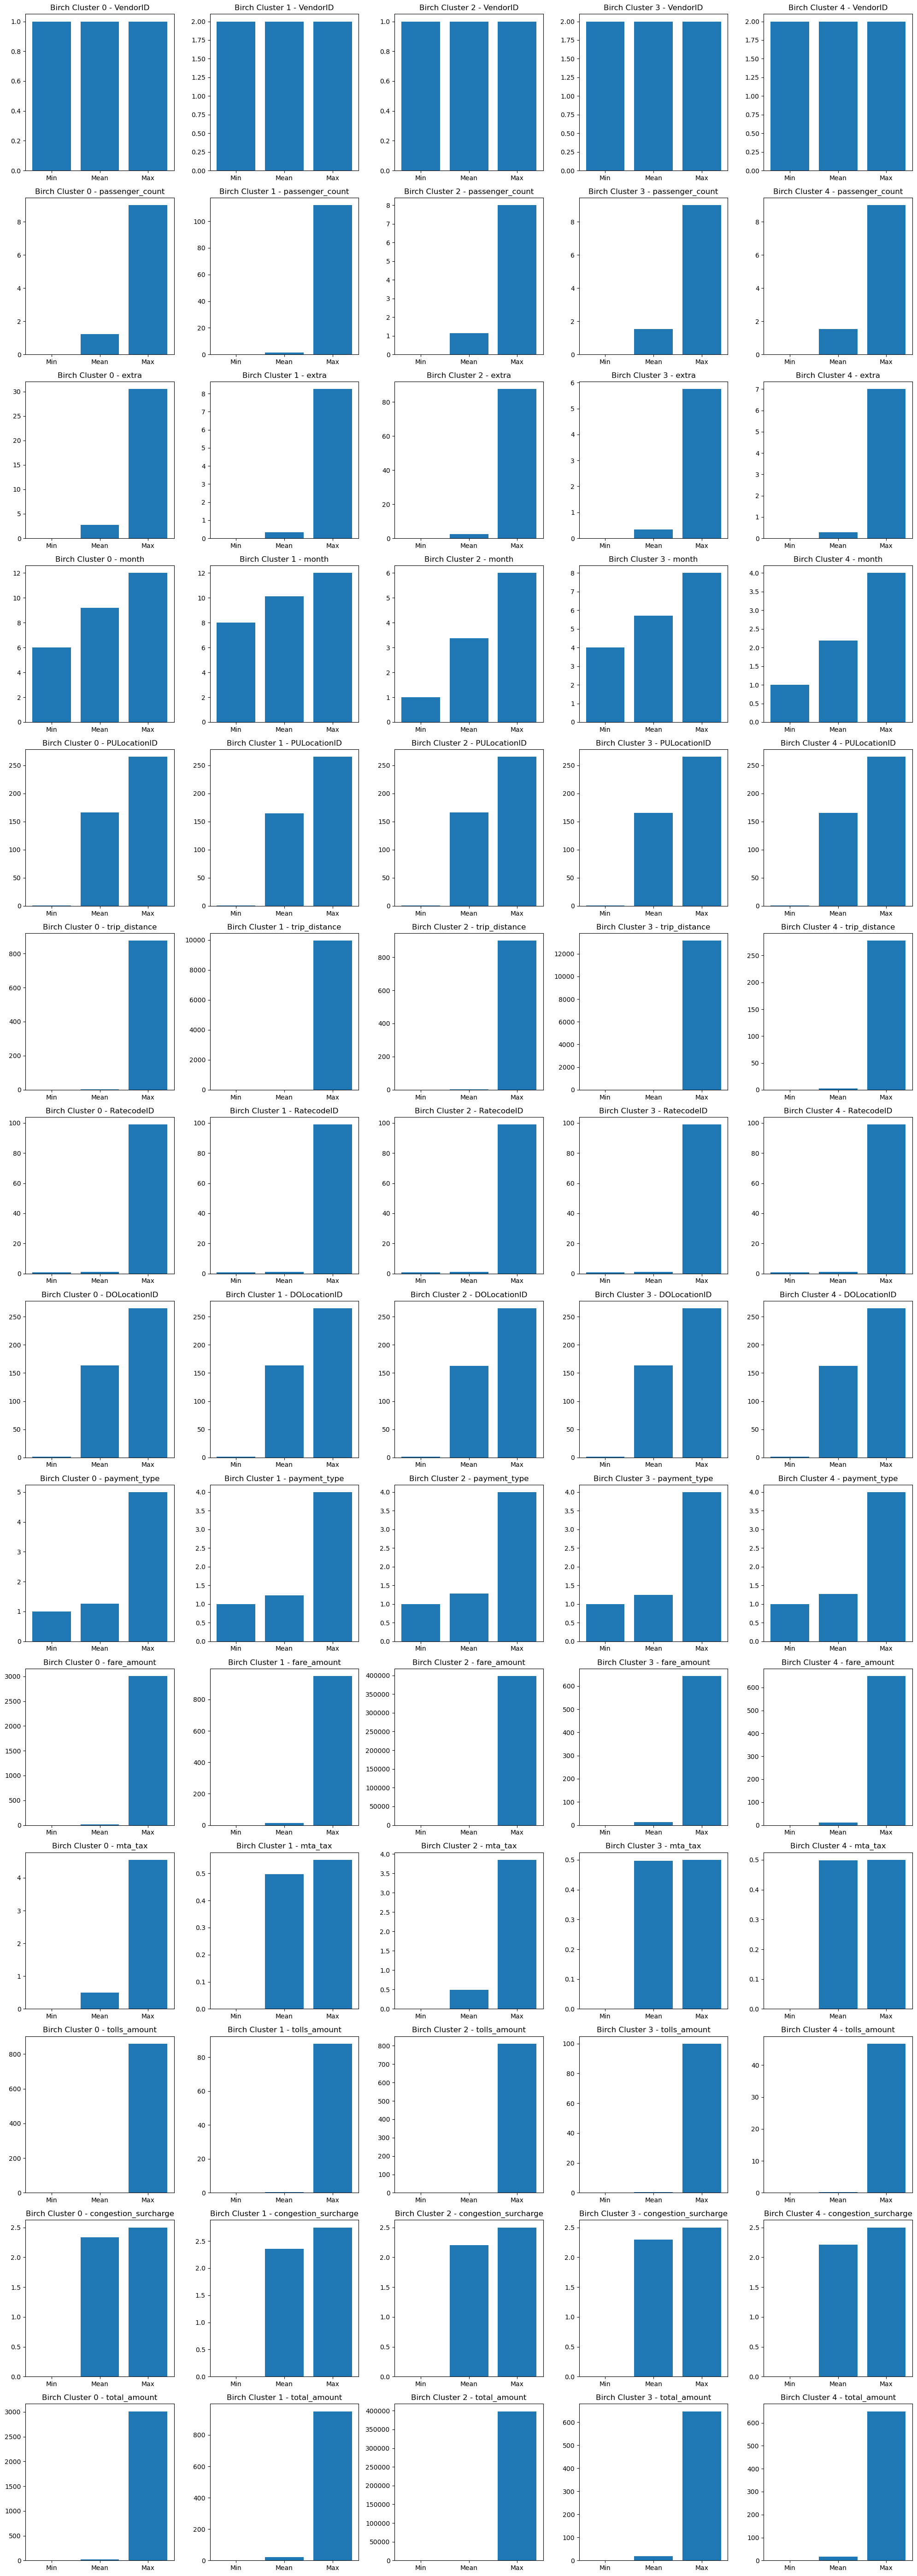

In [22]:
for i in range(len(lst_df)):
    df = lst_df[i]
    print(f'\nНабор данных - {i+1}й\n')
    # Группировка данных по кластерам
    grouped = df.groupby('Birch_clust')
    
    # Вычисление минимального, среднего и максимального значения для каждого признака в каждом кластере
    summary_stats = grouped.agg(dick_agg)
    
    # Построение графика
    fig, axs = plt.subplots(len(columns), len(summary_stats), figsize=(20, 4 * len(columns)))
    
    for j, feature in enumerate(columns):
        for i, (cluster, stats) in enumerate(summary_stats.iterrows()):
            axs[j, i].bar(['Min', 'Mean', 'Max'], stats[feature])
            axs[j, i].set_title(f'Birch Cluster {cluster} - {feature}')
    
    plt.tight_layout()
    plt.show()

График так же показывает что больше всех изменяемыми характеристиками являются trip_distance, fare_amount и total_amount.

Выведем сразу наборы данных и их клатеры. Просмотрим насколько они отлючаются от кластеров прошлой модели.

In [23]:
for df_i in range(len(lst_df)):
    df = lst_df[df_i]
    print(f'\nНабор данных - {df_i+1}й:')
    for i in range(5):
        print(f'Кластер {i}:')
        for column in columns_specifications:
            # Группировка данных по кластерам
            grouped = df.loc[:, [column, 'Birch_clust']].groupby('Birch_clust').get_group(i)
            print(f'\t{column}: min - {grouped.min()[0]}; mean - {grouped.mean()[0]}; max - {grouped.max()[0]};')
    print('')


Набор данных - 1й:
Кластер 0:
	trip_distance: min - 0.0; mean - 5.144870561013234; max - 603.5;
	fare_amount: min - 0.0; mean - 20.572109093123316; max - 411042.01;
	total_amount: min - 0.0; mean - 25.678206178452534; max - 411042.81;
Кластер 1:
	trip_distance: min - 0.0; mean - 2.6268343738299076; max - 701.3;
	fare_amount: min - 0.0; mean - 12.246417218000525; max - 3485.0;
	total_amount: min - 0.0; mean - 18.45377585279297; max - 3501.54;
Кластер 2:
	trip_distance: min - 0.0; mean - 6.920164922561739; max - 45977.22;
	fare_amount: min - 0.0; mean - 26.247076015069077; max - 2759.07;
	total_amount: min - 0.0; mean - 31.005131212501748; max - 2759.37;
Кластер 3:
	trip_distance: min - 0.0; mean - 3.043006091069172; max - 101.2;
	fare_amount: min - 0.0; mean - 13.376892716664546; max - 514.5;
	total_amount: min - 0.0; mean - 19.567601897363062; max - 970.3;
Кластер 4:
	trip_distance: min - 0.0; mean - 2.862646108949109; max - 311.56;
	fare_amount: min - 0.0; mean - 13.18864308688616; m

Так кластеры меняются в разных наборах, выделим примерные характеристики и их значения для каждого кластера:
        
    Кластер 1 - "Проезд - минимум": в данном кластере минимальное среднее значение(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 1; 
        Набор 2 - кластер под номером 4;
        Набор 3 - кластер под номером 4;
        
    Кластер 2 - "Проезд - меньше среднего": в данном кластере среднее значение ниже среднего(из всех кластеров) в trip_distance и fare_amount:
        Набор 1 - кластер под номером 4;
        Набор 2 - кластер под номером 0;
        Набор 3 - кластер под номером 2;
    
    Кластер 3 - "Проезд - средний": в данном кластере среднее значение находится в середине(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 3; 
        Набор 2 - кластер под номером 3;
        Набор 3 - кластер под номером 3;
    
    Кластер 4 - "Проезд - больше среднего": в данном кластере среднее значение выше среднего(из всех кластеров) в trip_distance и fare_amount:
        Набор 1 - кластер под номером 0;
        Набор 2 - кластер под номером 2;
        Набор 3 - кластер под номером 0;
    
    Кластер 5 - "Проезд - высокий": в данном кластере максимальное среднее значение(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 2; 
        Набор 2 - кластер под номером 1;
        Набор 3 - кластер под номером 1;

### GaussianMixture

Следующую модель обучим, так же записав в её в список, для дальнейшего урощения работы с метриками. Так же добавим в наборы данных столбец с кластерами для удобства опредления характеристик.

In [24]:
lst_gmm = []
for i in range(len(lst_pca)):
    gmm = GaussianMixture(n_clusters).fit(lst_pca[i])
    lst_gmm.append(gmm)

In [25]:
for i in range(len(lst_gmm)):
    print(f'Набор данных {i}')
    labels = lst_gmm[i].predict(lst_pca[i])

    # Подсчет количества записей в каждом кластере
    unique, counts = np.unique(labels, return_counts=True)
    
    # Вычисление процентов для каждого кластера
    total_count = np.sum(counts)
    cluster_percentages = [(count / total_count) * 100 for count in counts]
    
    # Вывод количества записей и процентов для каждого кластера
    for cluster, count, percentage in zip(unique, counts, cluster_percentages):
        print(f"Кластер {cluster}: {count} записей ({percentage:.2f}%)")

Набор данных 0
Кластер 0: 4876749 записей (29.85%)
Кластер 1: 1147911 записей (7.03%)
Кластер 2: 5489711 записей (33.60%)
Кластер 3: 3888912 записей (23.80%)
Кластер 4: 935881 записей (5.73%)
Набор данных 1
Кластер 0: 513931 записей (5.26%)
Кластер 1: 2137925 записей (21.87%)
Кластер 2: 1113204 записей (11.39%)
Кластер 3: 4311288 записей (44.11%)
Кластер 4: 1697563 записей (17.37%)
Набор данных 2
Кластер 0: 4380457 записей (36.31%)
Кластер 1: 3429683 записей (28.43%)
Кластер 2: 3327991 записей (27.58%)
Кластер 3: 304694 записей (2.53%)
Кластер 4: 622381 записей (5.16%)


Количество кластеров верное, данные распределены, потому записываем значения в набор данных атрибут Gauss_clust

In [26]:
for i in range(len(lst_gmm)):
    lst_df[i]['Gauss_clust'] = lst_gmm[i].predict(lst_pca[i])

С данной моделью проделаем те же действай. Для опрделения атрибутов которые меняются в зависимости от кластера, выведем график с отображением значением атрибутов в минимальной, среденей и максимальной позициий. Если графики будут отличаться в значениях, то можно опредлить эти признаки, как характеристики.


Набор данных - 1й



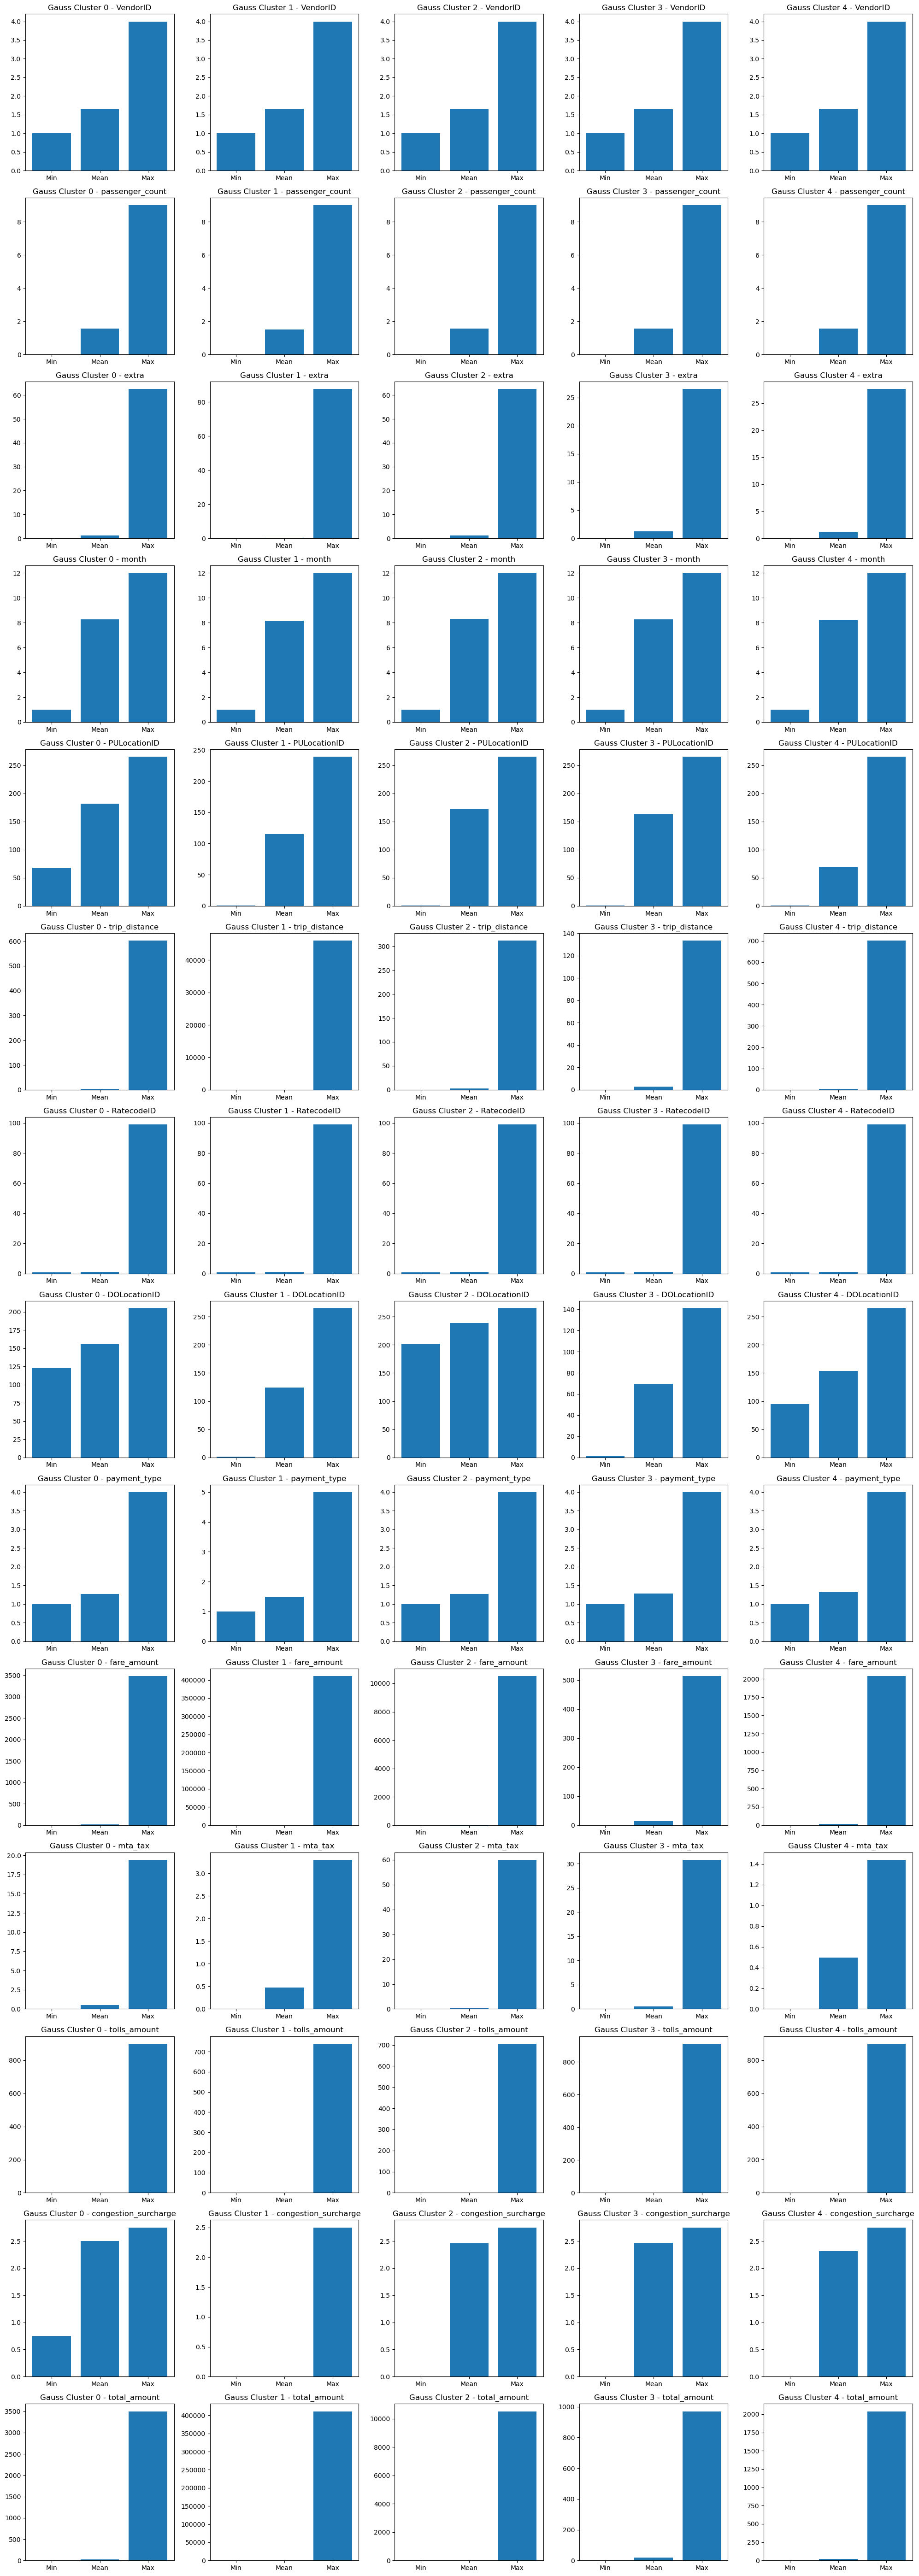


Набор данных - 2й



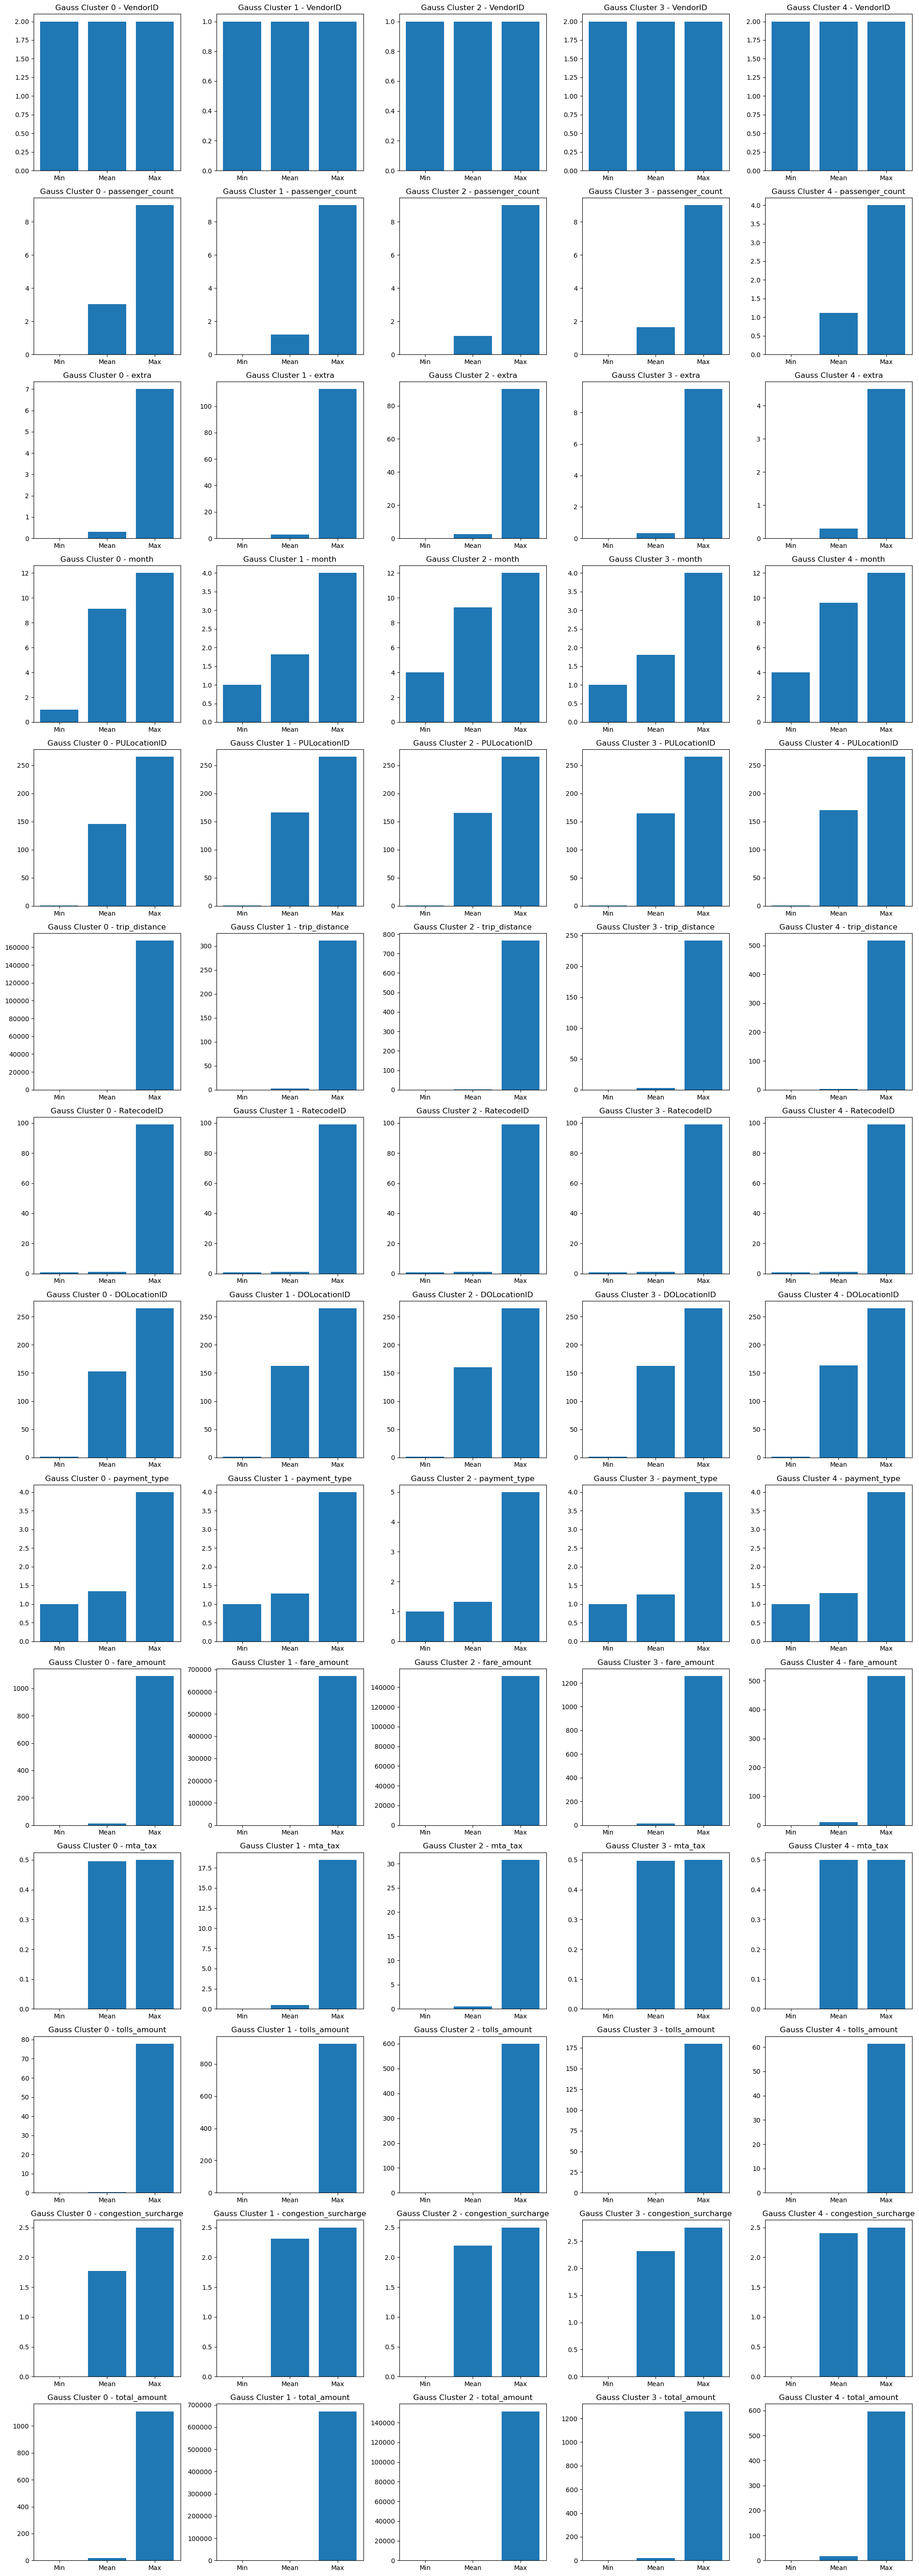


Набор данных - 3й



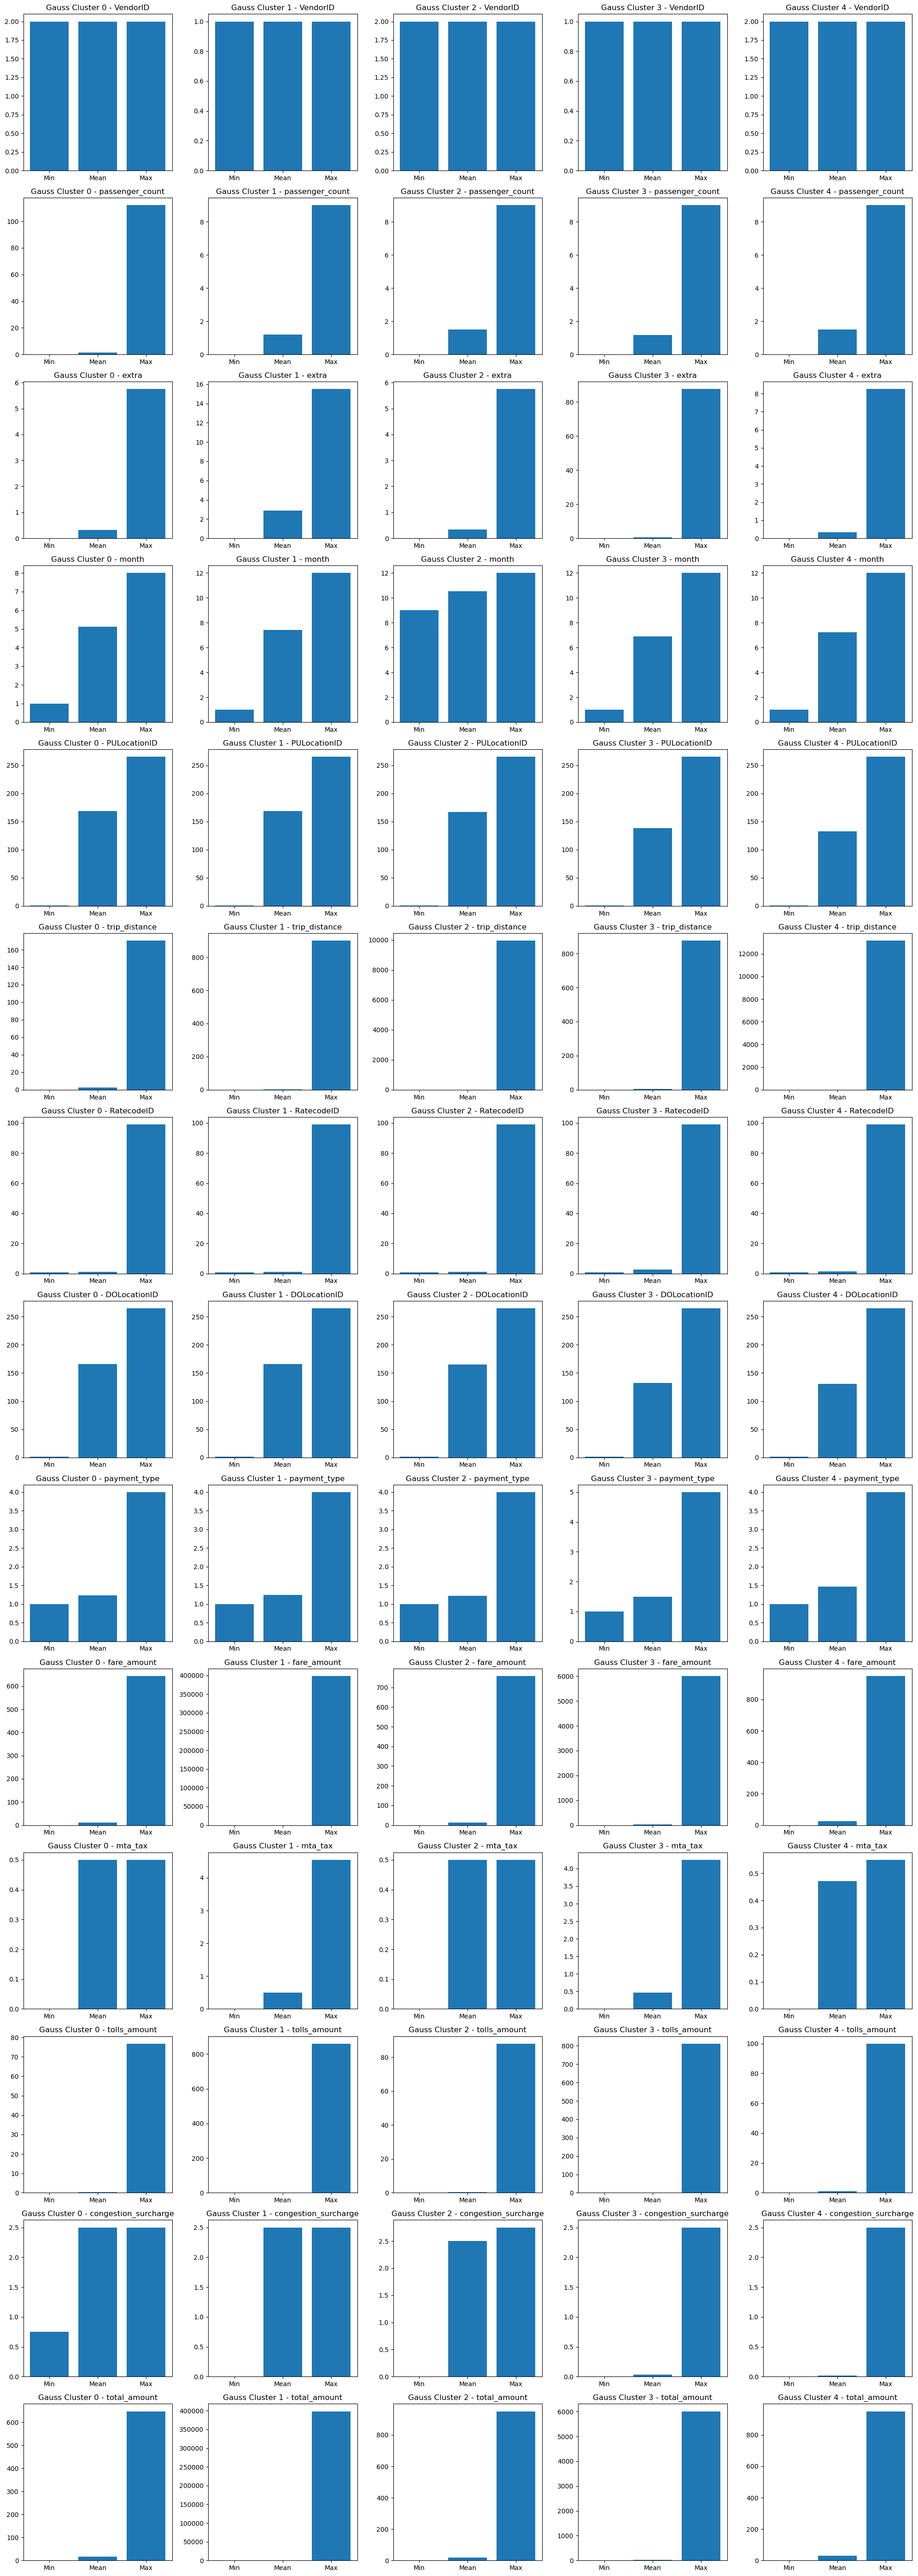

In [27]:
for i in range(len(lst_df)):
    df = lst_df[i]
    print(f'\nНабор данных - {i+1}й\n')
    # Группировка данных по кластерам
    grouped = df.groupby('Gauss_clust')
    
    # Вычисление минимального, среднего и максимального значения для каждого признака в каждом кластере
    summary_stats = grouped.agg(dick_agg)
    
    # Построение графика
    fig, axs = plt.subplots(len(columns), len(summary_stats), figsize=(20, 4 * len(columns)))
    
    for j, feature in enumerate(columns):
        for i, (cluster, stats) in enumerate(summary_stats.iterrows()):
            axs[j, i].bar(['Min', 'Mean', 'Max'], stats[feature])
            axs[j, i].set_title(f'Gauss Cluster {cluster} - {feature}')
    
    plt.tight_layout()
    plt.show()

График так же показывает что больше всех изменяемыми характеристиками являются trip_distance, fare_amount и total_amount.

Выведем сразу наборы данных и их клатеры. Просмотрим насколько они отлючаются от кластеров прошлой модели.

In [28]:
for df_i in range(len(lst_df)):
    df = lst_df[df_i]
    print(f'\nНабор данных - {df_i+1}й:')
    for i in range(5):
        print(f'Кластер {i}:')
        for column in columns_specifications:
            # Группировка данных по кластерам
            grouped = df.loc[:, [column, 'Gauss_clust']].groupby('Gauss_clust').get_group(i)
            print(f'\t{column}: min - {grouped.min()[0]}; mean - {grouped.mean()[0]}; max - {grouped.max()[0]};')
    print('')


Набор данных - 1й:
Кластер 0:
	trip_distance: min - 0.0; mean - 2.9370867005868044; max - 601.6;
	fare_amount: min - 0.0; mean - 13.188030152874374; max - 3485.0;
	total_amount: min - 0.0; mean - 19.71268897168995; max - 3501.54;
Кластер 1:
	trip_distance: min - 0.0; mean - 6.498721155211513; max - 45977.22;
	fare_amount: min - 0.0; mean - 24.860829689758177; max - 411042.01;
	total_amount: min - 0.0; mean - 29.613813509932378; max - 411042.81;
Кластер 2:
	trip_distance: min - 0.0; mean - 2.474619239519166; max - 311.56;
	fare_amount: min - 0.0; mean - 11.943821864211069; max - 10524.0;
	total_amount: min - 0.0; mean - 17.90430896271225; max - 10527.8;
Кластер 3:
	trip_distance: min - 0.0; mean - 2.9788863543325252; max - 133.52;
	fare_amount: min - 0.0; mean - 13.223596589483128; max - 514.5;
	total_amount: min - 0.0; mean - 19.37629231774852; max - 970.3;
Кластер 4:
	trip_distance: min - 0.0; mean - 2.9853228562178304; max - 701.3;
	fare_amount: min - 0.0; mean - 13.47079108348177; 

Так кластеры меняются в разных наборах, выделим примерные характеристики и их значения для каждого кластера:

    Кластер 1 - "Проезд - минимум": в данном кластере минимальное среднее значение(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 2; 
        Набор 2 - кластер под номером 4;
        Набор 3 - кластер под номером 0;
        
    Кластер 2 - "Проезд - меньше среднего": в данном кластере среднее значение ниже среднего(из всех кластеров) в trip_distance и fare_amount:
        Набор 1 - кластер под номером 3;
        Набор 2 - кластер под номером 2;
        Набор 3 - кластер под номером 1;
    
    Кластер 3 - "Проезд - средний": в данном кластере среднее значение находится в середине(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 4; 
        Набор 2 - кластер под номером 3;
        Набор 3 - кластер под номером 2;
    
    Кластер 4 - "Проезд - больше среднего": в данном кластере среднее значение выше среднего(из всех кластеров) в trip_distance и fare_amount:
        Набор 1 - кластер под номером 0;
        Набор 2 - кластер под номером 1;
        Набор 3 - кластер под номером 3;
    
    Кластер 5 - "Проезд - высокий": в данном кластере максимальное среднее значение(из всех кластеров) trip_distance и fare_amount:
        Набор 1 - кластер под номером 1; 
        Набор 2 - кластер под номером 0;
        Набор 3 - кластер под номером 4;

### Вывод

Для того чтобы провести успешную кластеризацию была проведена нормализация данных. После этого было определенно количество кластеров с помощью метода локтя в итоге для кластеризаций было выбрано 5 кластеров. Затем была уменьшена размерность данных и затем проведена кластеризация с помощью трёх методов: KMeans, Birch, GaussianMixture. Эти модели были выбранны из-за хорошей работы с большим количестовм данных.

После кластеризаций были определены характеристики с помощью графиков. Далее для каждого набора были определены кластеры с данными характеристиками. Имеется 5 кластеров:

    Кластер 1 - "Проезд - минимум": в данном кластере минимальное среднее значение(из всех кластеров) trip_distance и fare_amount;
        
    Кластер 2 - "Проезд - меньше среднего": в данном кластере среднее значение ниже среднего(из всех кластеров) в trip_distance и fare_amount;
    
    Кластер 3 - "Проезд - средний": в данном кластере среднее значение находится в середине(из всех кластеров) trip_distance и fare_amount;
    
    Кластер 4 - "Проезд - больше среднего": в данном кластере среднее значение выше среднего(из всех кластеров) в trip_distance и fare_amount;
    
    Кластер 5 - "Проезд - высокий": в данном кластере максимальное среднее значение(из всех кластеров) trip_distance и fare_amount;

## 2.2 Вычисление показателей производительности кластеризации

#### План:

    Выбор метрик для оценки кластеризаций;
    Оценка точности моделей с помощью выбранных метрик;
    Визуальный анализ кластерных структур;
    Визуальный анализ качества кластеризаций;
    Определение лучшего алгоритма кластеризаций;

### Выбор метрик

Для кластеризаций существует два типа метрик: метрики которые оценивают качество кластеризаций с помощью двух массивов с предсказанными значениями и правдивыми значениями и метрики которые оценивают качество кластеризаций с помощью расположения знчений кластеров(т.е. они не требуют правдивых значений и работают только с одним массивом).

Так как в наборах не имеется правдивых значений кластеров, будем использовать следующие метрики:

#### Calinski-Harabasz

Calinski-Harabasz, также известный как критерий V-отношения, оценивает отношение внутрикластерной дисперсии к межкластерной дисперсии. 
Интерпретация: Большие значения Calinski-Harabasz указывают на более четкую и различимую кластеризацию.

#### Davies-Bouldin 

Davies-Bouldin измеряет среднее отношение схожести каждого кластера с его наиболее похожим кластером и среднее расстояние между центроидами кластеров. 
Интерпретация: Чем ниже значение Davies-Bouldin, тем лучше кластеризация. Низкие значения указывают на более различимые кластеры.

__Silhouette Score__ использовать не будем, так как оценка происходит очень долго для данных наборов.

### Оценка точности моделей

Список нужен для работы с признакми кластеров в наборе данных.

In [29]:
lst_models = ['KMeans_clust', 'Birch_clust', 'Gauss_clust']

#### Calinski-Harabasz

In [30]:
lst_calinski_harabasz = []
for i in range(len(lst_df)):
    # Записываем в данные набор с столбцами типа int float
    data = lst_df[i].loc[:, columns]
    print(f"Набор данных - {i+1}")
    lst_ = []
    # Перебираем модели с помощью списка с названием признаком
    for model in lst_models:
        labels = lst_df[i].loc[:,model]
        # Оценка с помошью Калински
        calinski_harabasz = calinski_harabasz_score(data, labels)
        lst_.append(calinski_harabasz)
        print(f"\t{model}, оценка Калински: {calinski_harabasz}")
    # Записывам значения для дальнейшего графика
    lst_calinski_harabasz.append(lst_)
    print('')

Набор данных - 1
	KMeans_clust, оценка Калински: 954898.7590093658
	Birch_clust, оценка Калински: 753527.8622130647
	Gauss_clust, оценка Калински: 792080.2893608187

Набор данных - 2
	KMeans_clust, оценка Калински: 386.60549487802507
	Birch_clust, оценка Калински: 413.66919896726984
	Gauss_clust, оценка Калински: 991.7881113973282

Набор данных - 3
	KMeans_clust, оценка Калински: 1020.206289884017
	Birch_clust, оценка Калински: 961.1357551264664
	Gauss_clust, оценка Калински: 16525.704426517594



Для первого набора лучшим методом кластеризации оказалась KMeans, в двух других наборах же лучшим методом кластеризаций является GaussianMixture.

#### Davies-Bouldin

In [32]:
lst_davies_bouldin = []
for i in range(len(lst_df)):
    # Записываем в данные набор с столбцами типа int float
    data = lst_df[i].loc[:, columns]
    print(f"Набор данных - {i+1}")
    lst_ = []
    # Перебираем модели с помощью списка с названием признаком
    for model in lst_models:
        labels = lst_df[i].loc[:,model]
        # Оценка с помошью Дависа Боулдина
        davies_bouldin = davies_bouldin_score(data, labels)
        lst_.append(davies_bouldin)
        print(f"\t{model}, оценка Дависа Боулдина: {davies_bouldin}")
    # Записывам значения для дальнейшего графика
    lst_davies_bouldin.append(lst_)
    print('')

Набор данных - 1
	KMeans_clust, оценка Дависа Боулдина: 1.7825287396735034
	Birch_clust, оценка Дависа Боулдина: 3.093597494624558
	Gauss_clust, оценка Дависа Боулдина: 2.001928205896395

Набор данных - 2
	KMeans_clust, оценка Дависа Боулдина: 55.959816475368406
	Birch_clust, оценка Дависа Боулдина: 49.19901668910298
	Gauss_clust, оценка Дависа Боулдина: 36.64765199258846

Набор данных - 3
	KMeans_clust, оценка Дависа Боулдина: 56.75233843593389
	Birch_clust, оценка Дависа Боулдина: 56.27258025778785
	Gauss_clust, оценка Дависа Боулдина: 38.16168155803716



Для первого набора лучшим методом кластеризации оказалась KMeans, в двух других наборах же лучшим методом кластеризаций является GaussianMixture. Так же получилось и с прошлой метрикой.

Так же можно заметить, что в обоих случаях оценка лучше в первом наборе, возможно из-за того что значений больше в первом наборе.

### Визуальный анализ кластерных структур

Просмотрим данные с помощью PCA, как распологаются значения, распредление данных в кажом кластере.

#### Kmeans

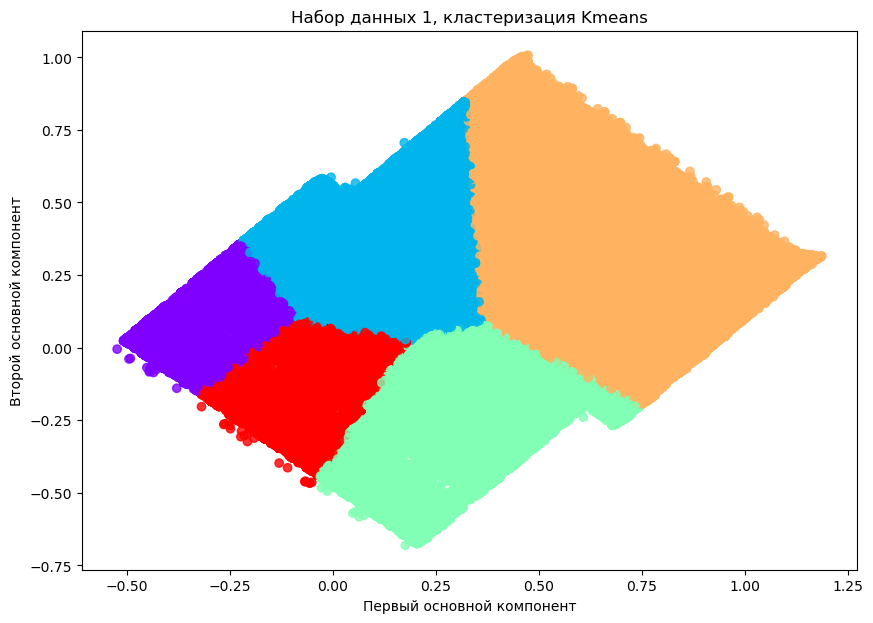

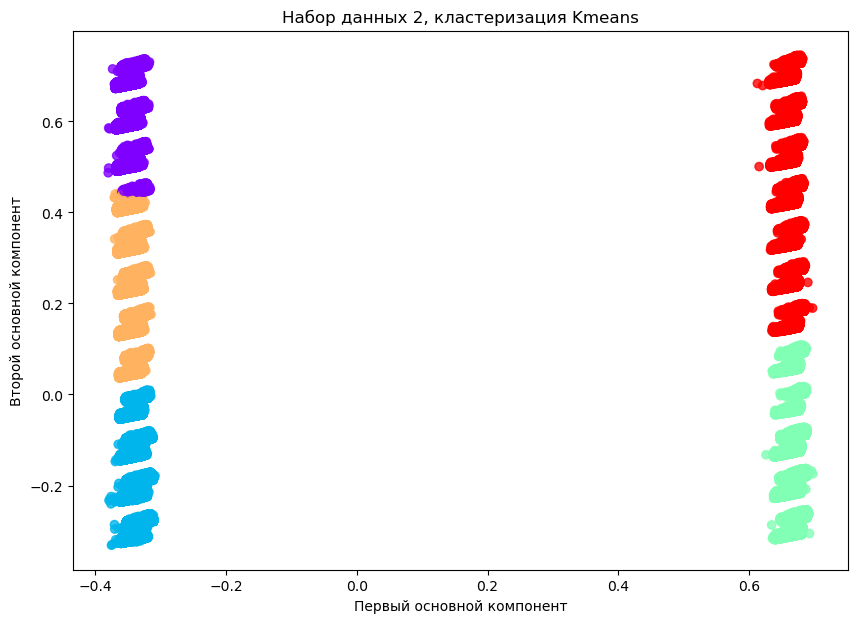

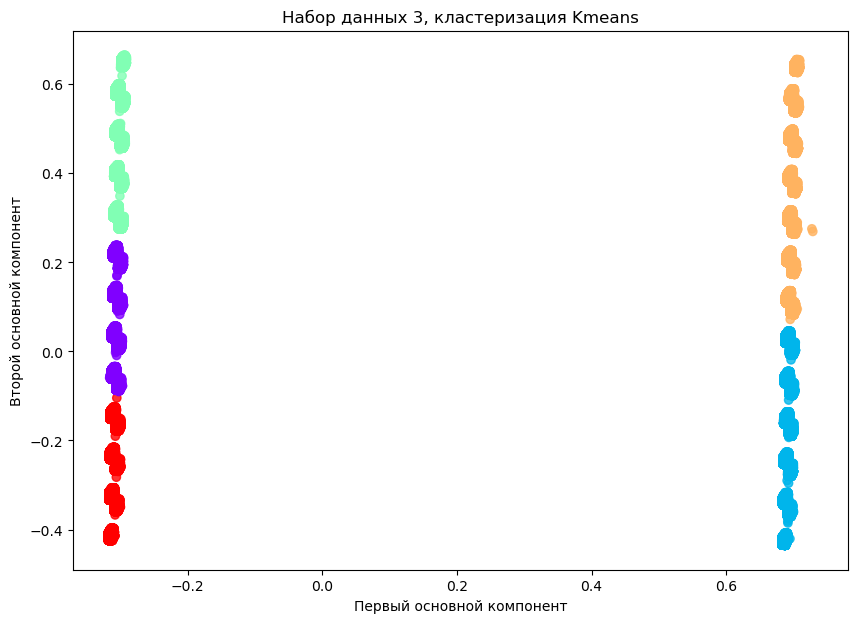

In [46]:
for i in range(len(lst_pca)):
    # Вывод графика для каждого набора
    plt.figure(figsize=(10,7))
    plt.scatter(lst_pca[i][:,0],lst_pca[i][:,1],c=lst_kmeans[i].labels_,cmap='rainbow', alpha=0.8)
    plt.title(f'Набор данных {i+1}, кластеризация Kmeans')
    plt.xlabel('Первый основной компонент')
    plt.ylabel('Второй основной компонент')
    plt.show()

Kmeans достаточно чётко распредлил данные в каждом наборе, так же можно заметить что распредление в каждом наборе отличается.

#### Birch

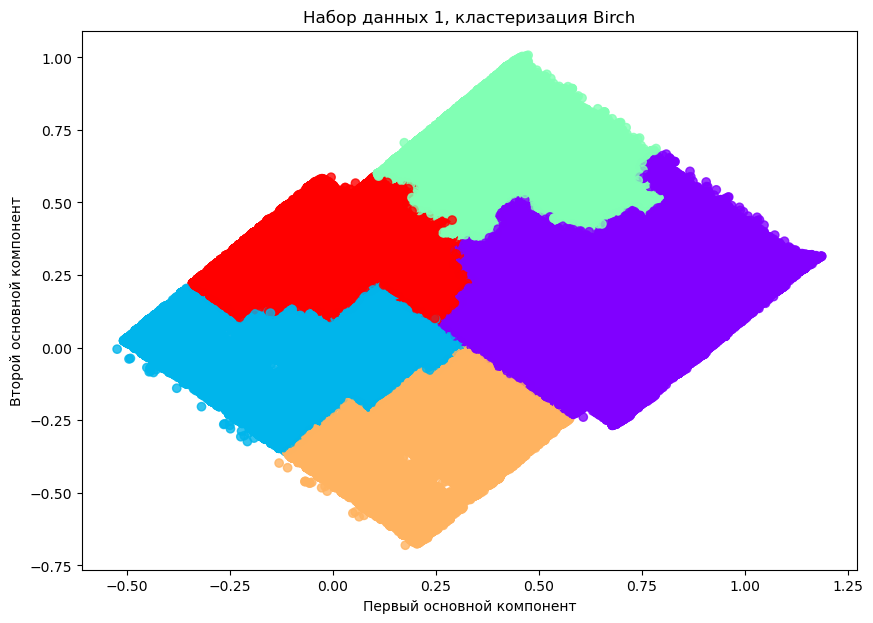

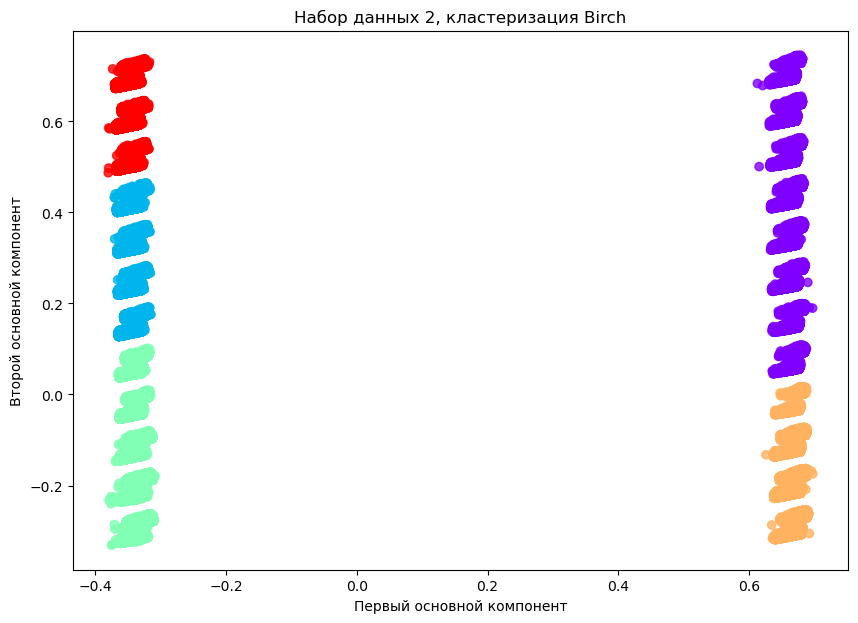

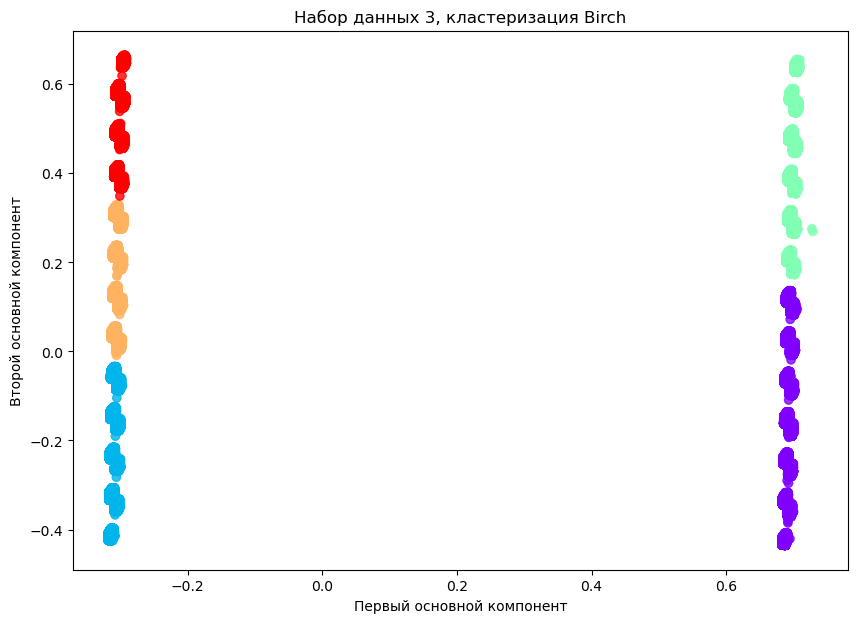

In [47]:
for i in range(len(lst_pca)):
    # Вывод графика для каждого набора
    plt.figure(figsize=(10,7))
    plt.scatter(lst_pca[i][:,0],lst_pca[i][:,1],c=lst_birch[i].predict(lst_pca[i]),cmap='rainbow', alpha=0.8)
    plt.title(f'Набор данных {i+1}, кластеризация Birch')
    plt.xlabel('Первый основной компонент')
    plt.ylabel('Второй основной компонент')
    plt.show()

Модель Birch во втором и третьем наборе расположил кластеры так же как Kmeans, с первым набором он сделал это сложнее и видно, что нет такого четкого распределения.

#### Gaussian

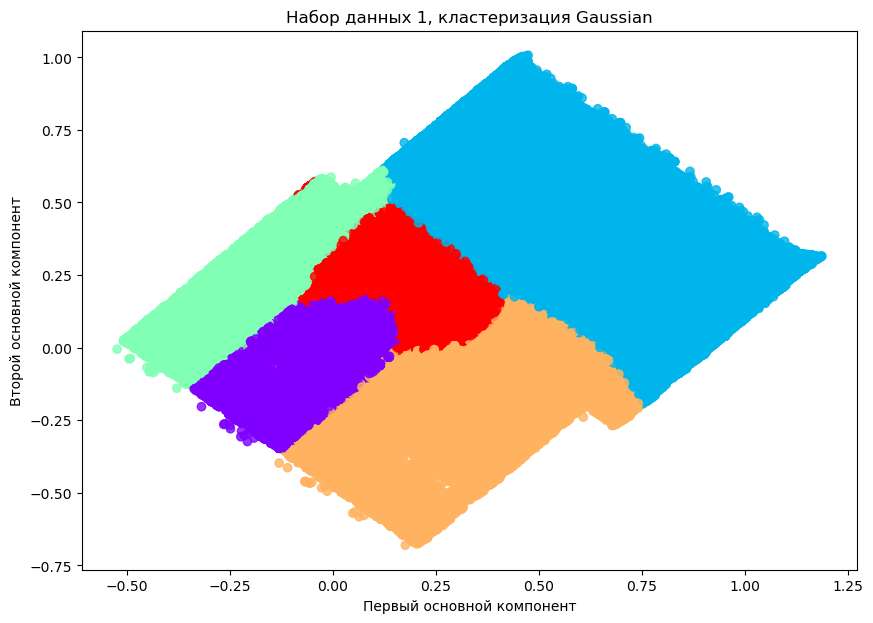

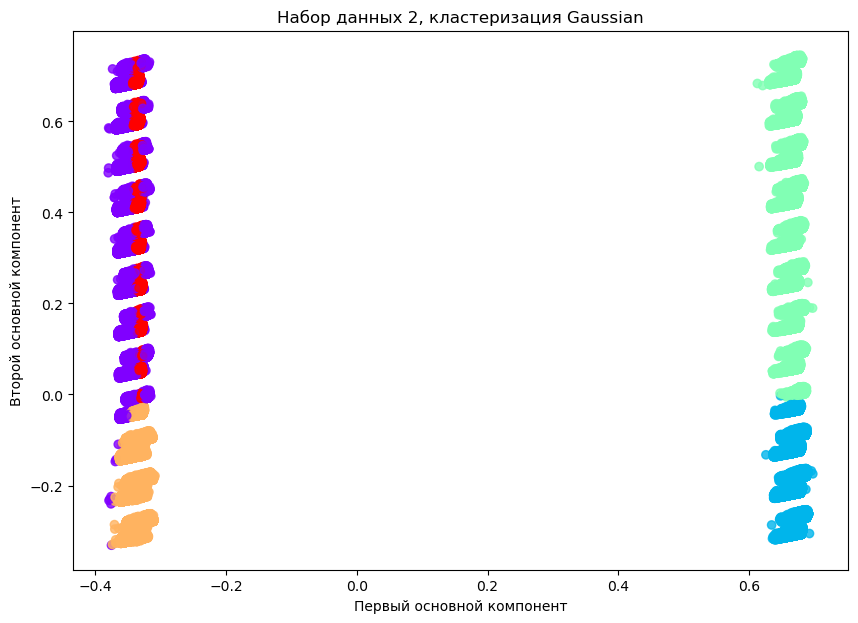

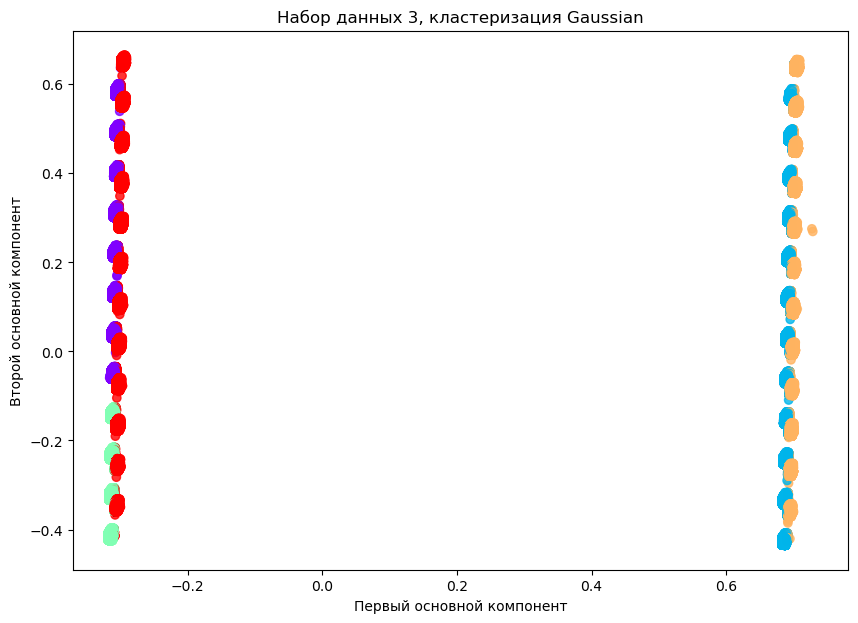

In [48]:
for i in range(len(lst_pca)):
    # Вывод графика для каждого набора
    plt.figure(figsize=(10,7))
    plt.scatter(lst_pca[i][:,0],lst_pca[i][:,1],c=lst_gmm[i].predict(lst_pca[i]),cmap='rainbow', alpha=0.8)
    plt.title(f'Набор данных {i+1}, кластеризация Gaussian')
    plt.xlabel('Первый основной компонент')
    plt.ylabel('Второй основной компонент')
    plt.show()

У метода Gaussian совсем другое распредление по кластерам. Скорей всего метод распределял данные по другой плоскост так как видно что в одном кластере содержаться другие.

### Визуальный анализ качества кластеризаций

Выведем графики оценки Калински. Для данной метрики чем больше значение, тем лучше оценка.

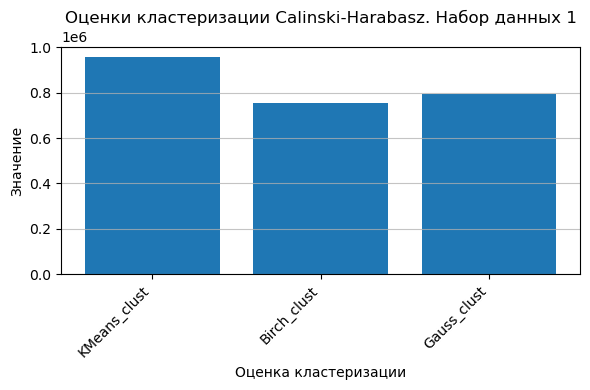

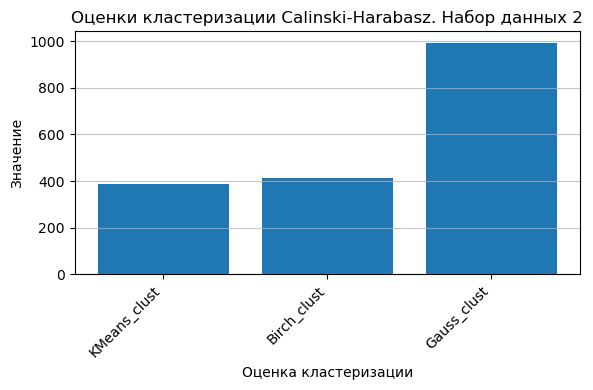

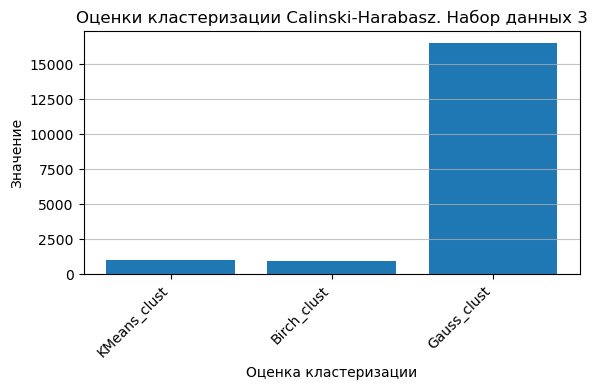

In [44]:
for df_i in range(len(lst_calinski_harabasz)):
    # С писке храняться оценки кластеризации
    values = lst_calinski_harabasz[df_i]
    
    fig, ax = plt.subplots(figsize=(6, 4))  
    # Построение столбчатой диаграммы
    ax.bar(lst_models, values)
    
    ax.set_xlabel(f'Оценка кластеризации')
    ax.set_xticklabels(lst_models, rotation=45, ha='right')
    ax.set_ylabel('Значение')
    ax.grid(axis='y', alpha=0.75)
    ax.set_title(f'Оценки кластеризации Calinski-Harabasz. Набор данных {df_i+1}')
    plt.tight_layout()
    plt.show()

Далее выведим график Дависа, здесь ситуация обратная - чем меньше значение, тем лучше оценка.

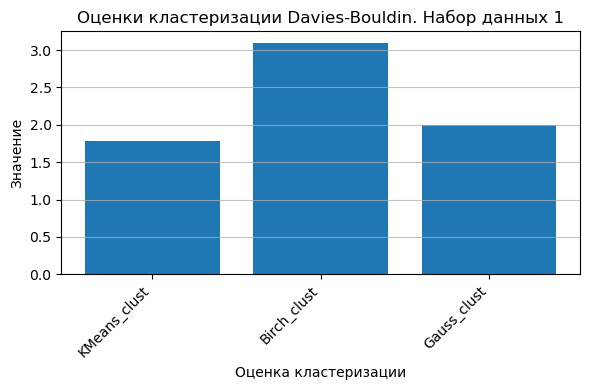

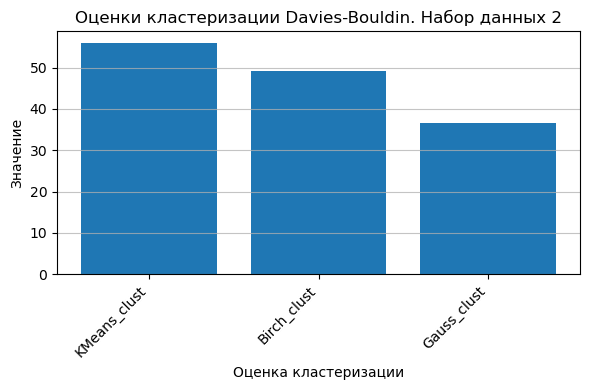

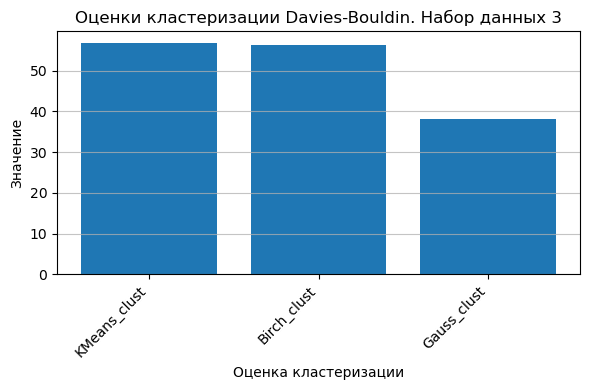

In [45]:
for df_i in range(len(lst_davies_bouldin)):
    # Список хранит оценки кластеризации
    values = lst_davies_bouldin[df_i]
    
    fig, ax = plt.subplots(figsize=(6, 4))  
    # Построение столбчатой диаграммы
    ax.bar(lst_models, values)
    
    ax.set_xlabel(f'Оценка кластеризации')
    ax.set_xticklabels(lst_models, rotation=45, ha='right')
    ax.set_ylabel('Значение')
    ax.grid(axis='y', alpha=0.75)
    ax.set_title(f'Оценки кластеризации Davies-Bouldin. Набор данных {df_i+1}')
    plt.tight_layout()
    plt.show()

Вывели графики для того чтобы легче понимать какой метод кластеризаций лучше. По графикам Калински видно что для первого набора лучшим методом кластеризации оказалась KMeans, в двух других наборах же лучшим методом кластеризаций является GaussianMixture. В Дависе полуилась точно такая же ситуация.

### Лучший алгоритм кластеризаций

Лучшим алгоритмом кластеризаций для первого набора данных был __Kmeans__, за счёт того что в нё было больше значений, метрики Калински и Дависа доказали это. 

Для двух других наборов лучшим методом является __GaussianMixture__, метрики Калински и Дависа доказали это.

Сохраним фреймы с кластерами и модели для дальнейших сессий. В первом наборе удаляем атрибуты Birch_clust и Gauss_clust. Во втором удаляем атрибуты Birch_clust и KMeans_clust. 

In [56]:
lst_df[0] = lst_df[0].drop(columns=['Birch_clust', 'Gauss_clust'])
lst_df[1] = lst_df[1].drop(columns=['Birch_clust', 'KMeans_clust'])
lst_df[2] = lst_df[2].drop(columns=['Birch_clust', 'KMeans_clust'])

In [57]:
lst_df[0].rename(columns = {'KMeans_clust':'cluster'}, inplace = True )
lst_df[1].rename(columns = {'Gauss_clust':'cluster'}, inplace = True )
lst_df[2].rename(columns = {'Gauss_clust':'cluster'}, inplace = True )

Создадим столбец с переименоваными кластерами.

In [61]:
def assign_name_cluster_2019(value):
    if value == 0:
        return 'Проезд - минимум'
    elif value == 1:
        return 'Проезд - больше среднего'
    elif value == 2:
        return 'Проезд - средний'
    elif value == 3:
        return 'Проезд - высокий'
    elif value == 4:
        return 'Проезд - меньше среднего'
    else:
        return 'Другое значение'

lst_df[0]['name_cluster'] = lst_df[0]['cluster'].apply(assign_name_cluster_2019)

In [62]:
def assign_name_cluster_2020(value):
    if value == 0:
        return 'Проезд - высокий'
    elif value == 1:
        return 'Проезд - больше среднего'
    elif value == 2:
        return 'Проезд - меньше среднего'
    elif value == 3:
        return 'Проезд - средний'
    elif value == 4:
        return 'Проезд - минимум'
    else:
        return 'Другое значение'

lst_df[1]['name_cluster'] = lst_df[1]['cluster'].apply(assign_name_cluster_2020)

In [63]:
def assign_name_cluster_2021(value):
    if value == 0:
        return 'Проезд - минимум'
    elif value == 1:
        return 'Проезд - меньше среднего'
    elif value == 2:
        return 'Проезд - средний'
    elif value == 3:
        return 'Проезд - больше среднего'
    elif value == 4:
        return 'Проезд - высокий'
    else:
        return 'Другое значение'

lst_df[2]['name_cluster'] = lst_df[2]['cluster'].apply(assign_name_cluster_2021)

In [64]:
lst_df[0].head()

VendorID  passenger_count tpep_pickup_datetime  extra  month  PULocationID  \
0       2.0              1.0  2009-01-01 00:03:44    1.0      1           138   
1       2.0              1.0  2009-01-01 00:28:54    0.0      1           234   
2       2.0              1.0  2009-01-01 10:51:34    0.5      1           233   
3       2.0              1.0  2009-01-01 01:05:31    0.0      1           239   
4       2.0              3.0  2009-01-01 00:08:28    0.0      1            24   

   trip_distance  RatecodeID  DOLocationID  payment_type  fare_amount  \
0          10.67         1.0           164           1.0         36.0   
1           9.96         1.0           138           2.0         28.5   
2           2.21         1.0            90           2.0         12.5   
3           2.03         1.0           239           2.0          8.0   
4           3.30         1.0           230           2.0         13.5   

   mta_tax  tolls_amount  congestion_surcharge  total_amount  cluster  \
0      0.5          6.12                   2.5         55.70        4   
1      0.5          6.12                   2.5         37.92        4   
2      0.5          0.00                   2.5         16.30        2   
3      0.5          0.00                   2.5         11.30        0   
4      0.5          0.00                   2.5         16.80        1   

               name_cluster  
0  Проезд - меньше среднего  
1  Проезд - меньше среднего  
2          Проезд - средний  
3          Проезд - минимум  
4  Проезд - больше среднего

In [65]:
# Сохранение наборов с кластерами
lst_df[0].to_csv(r'clust_df2019.csv', index=False, encoding='utf-8')
lst_df[1].to_csv(r'clust_df2020.csv', index=False, encoding='utf-8')
lst_df[2].to_csv(r'clust_df2021.csv', index=False, encoding='utf-8')

In [60]:
# Сохранение моделей кластеризаций
with open('model_kmeans_df2019.pkl', 'wb') as file:
    pickle.dump(lst_kmeans[0], file)

with open('model_gmm_df2020.pkl', 'wb') as file:
    pickle.dump(lst_gmm[1], file)

with open('model_gmm_df2021.pkl', 'wb') as file:
    pickle.dump(lst_gmm[2], file)

### Вывод

Для оценки кластеризаций были выбраны и оценены следующие метрики: Calinski-Harabasz и 

Davies-Boul. Обе метрики показали одинаковый результат - для первого набора лучшим методом кластеризации оказалась KMeans, в двух других наборах же лучшим методом кластеризаций является GaussianMixture.

Был выполнен визуальный анализ кластерных структур, был сделан вывод:

    Kmeans достаточно чётко распредлил данные в каждом наборе, так же можно заметить что распредление в каждом наборе отличается.
    Модель Birch во втором и третьем наборе расположил кластеры так же как Kmeans, с первым набором он сделал это сложнее и видно, что нет такого четкого распределения.
    У метода Gaussian совсем другое распредление по кластерам. Скорей всего метод распределял данные по другой плоскост так как видно что в одном кластере содержаться другие.

Так же были отображены графики с оценками методов кластеризаций.

Были определены лучшие методы кластеризаций. Лучшим алгоритмом кластеризаций для первого набора данных был Kmeans, за счёт того что в нё было больше значений, метрики Калински и Дависа доказали это. Для двух других наборов лучшим методом является GaussianMixture.
еры.

## 2.3 Подготовка отчета

#### 2.1 Кластеризация набора данных

Для того чтобы провести успешную кластеризацию была проведена нормализация данных. После этого было определенно количество кластеров с помощью метода локтя в итоге для кластеризаций было выбрано 5 кластеров. Затем была уменьшена размерность данных и затем проведена кластеризация с помощью трёх методов: KMeans, Birch, GaussianMixture. Эти модели были выбранны из-за хорошей работы с большим количестовм данных.

После кластеризаций были определены характеристики с помощью графиков. Далее для каждого набора были определены кластеры с данными характеристиками. Имеется 5 кластеров:

    Кластер 1 - "Проезд - минимум": в данном кластере минимальное среднее значение(из всех кластеров) trip_distance и fare_amount;
        
    Кластер 2 - "Проезд - меньше среднего": в данном кластере среднее значение ниже среднего(из всех кластеров) в trip_distance и fare_amount;
    
    Кластер 3 - "Проезд - средний": в данном кластере среднее значение находится в середине(из всех кластеров) trip_distance и fare_amount;
    
    Кластер 4 - "Проезд - больше среднего": в данном кластере среднее значение выше среднего(из всех кластеров) в trip_distance и fare_amount;
    
    Кластер 5 - "Проезд - высокий": в данном кластере максимальное среднее значение(из всех кластеров) trip_distance и fare_amount;

#### 2.2 Вычисление показателей производительности кластеризации

Для оценки кластеризаций были выбраны и оценены следующие метрики: Calinski-Harabasz и Davies-Bouldin. Обе метрики показали одинаковый результат - для первого набора лучшим методом кластеризации оказалась KMeans, в двух других наборах же лучшим методом кластеризаций является GaussianMixture.

Был выполнен визуальный анализ кластерных структур, был сделан вывод:

    Kmeans достаточно чётко распредлил данные в каждом наборе, так же можно заметить что распредление в каждом наборе отличается.
    Модель Birch во втором и третьем наборе расположил кластеры так же как Kmeans, с первым набором он сделал это сложнее и видно, что нет такого четкого распределения.
    У метода Gaussian совсем другое распредление по кластерам. Скорей всего метод распределял данные по другой плоскост так как видно что в одном кластере содержаться другие.

Так же были отображены графики с оценками методов кластеризаций.

Были определены лучшие методы кластеризаций. Лучшим алгоритмом кластеризаций для первого набора данных был Kmeans, за счёт того что в нё было больше значений, метрики Калински и Дависа доказали это. Для двух других наборов лучшим методом является GaussianMixture.


#### 2.3 Подготовка отчета

Был создан отчёт Report.html + Report.ipynb и файл Readme.txt, записали всё в Data.zip.